In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path
import yaml
import re

import pyarrow as pa
import pyarrow.parquet as pq

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

import vivarium_helpers as vh
import vivarium_helpers.id_helper as idh
from vivarium_helpers.vph_output.operations import VPHOperator
from vivarium_helpers.vph_output import cleaning

!date
!whoami
!pwd

Tue Oct 28 23:53:42 PDT 2025
ndbs
/mnt/share/code/ndbs/vivarium_research_alzheimers/verification_and_validation


# Note: This notebook runs V&V on run 8.2 with one draw and 500 seeds, treating each seed as a draw

The purpose of model 8.2 was to estimate stochastic uncertainty as a
function of population size, in order to determine a good population size
for the final model runs for 10/31. Specifically, the plan is to look at
the uncertainty in the number of averted deaths, which is computed near
the end of this notebook.

The main purpose of this notebook was to test the functionality of
`vivarium_helpers` to see if it could an unusual case where we are
interested in variation between random seeds instead of between input
draws. The answer is yes, it can -- all you have to do is tell the
`VPHOperator` object that the "input draw" column is actually the random
seed column, and everything works beautifully.

I was planning to create another notebook to do just the averted deaths
calculation, computing it multiple times. Namely for each factor $m$ of
500, we could aggregate the random seeds in groups of $m$, and then have
$500/m$ "draws" corresponding to that particular aggregation.
Specifically, I was thinking of doing the calculation for aggregations
of $m=1, 2, 4, 5, 10, 20$, and looking at 25 "draws" for each of these
aggregations to make the uncertainty between them comparable. Each
random seed is 20K simulants, so the largest population size here would
be 400K. If we only looked at 20 draws instead of 25, we could go up to
25 seeds, or a population of 500K.

# Record versions of Vivarium libraries

In [3]:
!pip list | grep vivarium

vivarium                                 3.4.12
vivarium_build_utils                     2.0.4
vivarium_cluster_tools                   2.1.17
vivarium_csu_alzheimers                  0.1.dev18+g43e997c.d20250808 /mnt/share/code/ndbs/vivarium_csu_alzheimers
vivarium_dependencies                    1.0.1
vivarium_gbd_access                      4.2.4
vivarium_helpers                         0.2.0                        /mnt/share/code/ndbs/vivarium_helpers/src
vivarium_inputs                          6.0.4
vivarium_public_health                   4.3.5


In [4]:
!pip freeze | grep vivarium

vivarium==3.4.12
vivarium_build_utils==2.0.4
vivarium_cluster_tools==2.1.17
-e git+https://github.com/ihmeuw/vivarium_csu_alzheimers.git@fc5ccf522118f76d1032f9ecf80b90ed4bef40c2#egg=vivarium_csu_alzheimers
vivarium_dependencies==1.0.1
vivarium_gbd_access==4.2.4
-e git+https://github.com/ihmeuw/vivarium_helpers.git@f040c20ca2e1d7d87c3ceae59134c43835acd3e7#egg=vivarium_helpers
vivarium_inputs==6.0.4
vivarium_public_health==4.3.5


# V&V List


1. Positive BBBM tests result in treatment initiation rates that match
    the year/location specific rates from in the [treatment intervention
    data table](https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/alzheimers/hypothetical_treatment.html#alzheimers-intervention-treatment-data-table)

1. 10% of transitions to Full treatment effect status are by simulants who discontinue treatment

1. Full/Waning durations are accurate (use person-time ratios between states?)

1. “In treatment/waiting for treatment” duration is accurate (use person-time ratios between states?)

1.  Interactive sim verification spot checking a simulant’s durations in
    treatment statuses as they move through BBBM test negative, Full
    treatment effect, Waning treatment effect, No treatment effect
    statuses (for both completed and discontinued treatments)

1.  Check hazard ratios for simulants who begin treatment and those who
    transition to *No treatment effect* (Check hazard ratio of treated to
    not treated for hazard rate from BBBM to MCI)

Time- and location-specific treatment initiation rate from treatment
intervention data table:

> Lilly: “The percent of patients with a positive BBBM test who initiate treatment will vary by location and over time – but will not vary by age or sex. In the US: 30% of eligible patients initiate (constant 2030-2100); Japan: 80% of eligible patients initiate (constant 2030-2100); all other countries: 40% of eligible patients initiate in 2030, increasing linearly to 70% by 2035, remaining constant at 70% until 2100.””

# Find data

```
/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/abie_consistent_model_test/united_states_of_america/2025_10_27_14_30_10/results/
```

The following artifact is not the one that was used, but should be close
enough:

```
/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/
```

In [5]:
# Project directory
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [6]:
# Results directory containing model 7 results for all locations
model_run_subdir = 'results/abie_consistent_model_test/united_states_of_america/2025_10_27_14_30_10/'
!ls -halt $model_run_subdir/results

total 77M
drwxrwsr-x 5 abie IHME-Simulationscience  4.5K Oct 27 14:53 ..
drwxrwsr-x 2 abie IHME-Simulationscience  6.5K Oct 27 14:53 .
-rw-rw-r-- 1 abie IHME-Simulationscience   19M Oct 27 14:53 person_time_alzheimers_disease_and_other_dementias.parquet
-rw-rw-r-- 1 abie IHME-Simulationscience 1023K Oct 27 14:53 person_time_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 abie IHME-Simulationscience  7.3M Oct 27 14:53 person_time_treatment.parquet
-rw-rw-r-- 1 abie IHME-Simulationscience   19M Oct 27 14:53 ylds.parquet
-rw-rw-r-- 1 abie IHME-Simulationscience  1.9M Oct 27 14:52 deaths.parquet
-rw-rw-r-- 1 abie IHME-Simulationscience  3.0M Oct 27 14:52 counts_baseline_tests_among_eligible.parquet
-rw-rw-r-- 1 abie IHME-Simulationscience  7.3M Oct 27 14:52 transition_count_alzheimers_disease_and_other_dementias.parquet
-rw-rw-r-- 1 abie IHME-Simulationscience  1.1M Oct 27 14:52 counts_new_simulants.parquet
-rw-rw-r-- 1 abie IHME-Simulationscience  4.7M Oct 27 14:52 person_time_ever_eligibl

In [7]:
!ls $model_run_subdir

__pycache__		   keyspace.yaml	     requirements.txt
branches.yaml		   logs			     results
finished_sim_metadata.csv  model_specification.yaml  settings.py


In [8]:
!cat $model_run_subdir/model_specification.yaml | grep -e artifact -e results

      controller: vivarium.framework.artifact.ArtifactManager
      builder_interface: vivarium.framework.artifact.ArtifactInterface
    results:
      controller: vivarium.framework.results.ResultsManager
      builder_interface: vivarium.framework.results.ResultsInterface
    results:
    artifact_path: /homes/abie/projects/2025/vivarium_csu_alzheimers/united_states_of_america.hdf
      - bbbm_test_results
    results_directory: /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/abie_consistent_model_test/united_states_of_america/2025_10_27_14_30_10


In [9]:
locations = [
    'United States of America',
    # 'Brazil',
    # 'China',
    # 'Germany',
    # 'Israel',
    # 'Japan',
    # 'Spain',
    # 'Sweden',
    # 'Taiwan (Province of China)',
    # 'United Kingdom',
]

# Define some shorter names to use for plotting
location_to_short_name = ({loc: loc for loc in locations} | {
    'Taiwan (Province of China)': 'Taiwan',
    'United Kingdom': 'UK',
    'United States of America': 'USA',
})

# # Select a subset of locations to draw plots for
# locations_to_plot = locations[:2]

project_dir = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

artifact_model_number = '8.3' # Artifacts are stored here
run_subdirectories = [
    model_run_subdir,
]
run_dirs = [project_dir + run_subdir for run_subdir in run_subdirectories]
results_dirs = [run_dir + 'results/' for run_dir in run_dirs]

# Option 1: One results directory per location
location_to_results_dir = {
    loc: path for loc, path in zip(locations, results_dirs)}

# # Option 2: All locations in one results directory
# location_to_results_dir = {'all': results_dirs[0]}

location_to_artifact_subdir = {loc: loc.lower().replace(' ', '_') for loc in locations}
artifact_subpaths = [f'artifacts/model{artifact_model_number}/' + subdir + '.hdf' for subdir in location_to_artifact_subdir.values()]
location_to_artifact_path = {loc: project_dir + subpath for loc, subpath in zip(locations, artifact_subpaths)}
location_to_artifact_path

{'United States of America': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf'}

In [10]:
location_to_results_dir

{'United States of America': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/abie_consistent_model_test/united_states_of_america/2025_10_27_14_30_10/results/'}

# Define some ordered Categorical dtypes, and convert years to ints

In [11]:
# # Instead of creating this dtype here, create an appropriate dtype in
# # the load_sim_output function.
# # Order locations lexicographically
# all_locations = [
#     'United States of America',
#     'Brazil',
#     'China',
#     'Germany',
#     'Israel',
#     'Japan',
#     'Spain',
#     'Sweden',
#     'Taiwan (Province of China)',
#     'United Kingdom',
# ]
# location_dtype = pd.CategoricalDtype(sorted(all_locations), ordered=True)

# Order years chronologically (for some reason years are strings in the output)
# years = [str(year) for year in range(2025, 2101)]
# year_dtype = pd.CategoricalDtype(years, ordered=True)
# int16 ranges from -32768 to 32767 (I think), which is sufficient to
# represent all years 2025-2100. uint8 only goes from 0 to 255, which is
# too small.
year_dtype = 'int16'

# Order age groups chronologically
age_groups = [f'{age}_to_{age + 4}' for age in range(25, 95, 5)] + ['95_plus']
age_group_dtype = pd.CategoricalDtype(age_groups, ordered=True)

# Order scenarios by complexity
scenarios = ['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
scenario_dtype = pd.CategoricalDtype(scenarios, ordered=True)

colname_to_dtype = {
    # 'location': location_dtype,
    'event_year': year_dtype,
    'age_group': age_group_dtype,
    'scenario': scenario_dtype,
}

# Load one artifact and define age bins

In [12]:
artifact_path = location_to_artifact_path[locations[0]]
art = Artifact(artifact_path)
print(art.load('metadata.locations'))
print(art)

['United States of America']
Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		excess_mortality_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		disability_weight
		restrictions
		cause_specific_mortality_rate
	alzheimers_consistent
		population_incidence_any
		prevalence_any
		population_incidence_dementia
		excess_mortality_rate
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		ode_errors
		susceptible_to_bbbm_transition_count
		dementia_conditional_prevalence
covariate
	live_births_by_sex
		estimate
testing_rates
	csf
	pet
treatment
	relative_risk



In [13]:
# age_bins is an empty DataFrame with a MultiIndex storing age group data
age_bins = art.load('population.age_bins')
age_dictionary = (
    age_bins
    .reset_index()
    .assign(age_group=lambda df: df['age_group_name'].str.replace(' ', '_'))
    # Filter to ages that actually appear in our sim
    .query("age_start >= 25")
)
age_dictionary

,age_group_id,age_group_name,age_start,age_end,age_group
4,10,25 to 29,25.0,30.0,25_to_29
5,11,30 to 34,30.0,35.0,30_to_34
6,12,35 to 39,35.0,40.0,35_to_39
7,13,40 to 44,40.0,45.0,40_to_44
8,14,45 to 49,45.0,50.0,45_to_49
9,15,50 to 54,50.0,55.0,50_to_54
10,16,55 to 59,55.0,60.0,55_to_59
11,17,60 to 64,60.0,65.0,60_to_64
12,18,65 to 69,65.0,70.0,65_to_69
13,19,70 to 74,70.0,75.0,70_to_74


# See what the treatment relative risk looks like

Draws should be uniformly distributed in $[0.4, 0.6]$.

In [14]:
treatment_rr = art.load('treatment.relative_risk')
treatment_rr

,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,draw_6,draw_7,draw_8,draw_9,...,draw_490,draw_491,draw_492,draw_493,draw_494,draw_495,draw_496,draw_497,draw_498,draw_499
0,0.527516,0.495529,0.464333,0.576056,0.478925,0.458396,0.541982,0.520483,0.53923,0.514836,...,0.485136,0.498684,0.503797,0.432717,0.462276,0.481699,0.569136,0.502568,0.4362,0.512734


# Define functions to load and merge Artifact data from all locations, and to summarize Artifact data for plotting

In [15]:
def load_artifact_data(
    key,
    filter_terms=None,
    location_to_artifact_path=location_to_artifact_path,
):
    dfs = {} # dict to map locations to artifact data
    for location, path in location_to_artifact_path.items():
        art = Artifact(path, filter_terms)
        # Check to make sure location matches artifact
        art_locations = art.load('metadata.locations')
        assert len(art_locations) == 1 and art_locations[0] == location, \
            f'Unexpected locations in artifact: {location=}, {art_locations=}'
        df = art.load(key)
        dfs[location] = df
    data = pd.concat(dfs, names=['location', *df.index.names])
    return data

def lower(x):
    return x.quantile(0.025)

def upper(x):
    return x.quantile(0.975)

def summarize_artifact_data(df):
    summary = df.agg(['mean', lower, upper], axis='columns')
    return summary

# Define functions to load simulation output and summarize it for plotting

With the `pyarrow` engine, `pandas.read_parquet()` calls `pyarrow.parquet.read_table()` and
`pyarrow.Table.to_pandas()`. Additional keyword arguments passed to
`pandas.read_parquet()` are passed to `pyarrow.parquet.read_table()`.

https://arrow.apache.org/docs/python/generated/pyarrow.parquet.read_table.html#pyarrow.parquet.read_table

https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.to_pandas

Pyarrow Dictionary arrays are analogous to pandas Categoricals:

https://arrow.apache.org/docs/python/data.html#data-dictionary

Pyarrow data types:

https://arrow.apache.org/docs/python/api/datatypes.html

https://arrow.apache.org/docs/python/generated/pyarrow.types.is_floating.html


Google AI results for "find column names in parquet file":

```python
import pyarrow.parquet as pq

# Replace 'your_file.parquet' with the actual path to your Parquet file
parquet_file_path = 'your_file.parquet'

# Read the Parquet file's schema
parquet_schema = pq.read_schema(parquet_file_path)

# Extract column names
column_names = parquet_schema.names

print(f"Column names in '{parquet_file_path}':")
for name in column_names:
    print(name)
```

In [16]:
# Create an operator object - treat each random seed as a separate draw,
# and add location to the index
ops = VPHOperator(draw_col='random_seed', location_col=True)
# ops.index_cols.extend(['location', 'random_seed'])

def load_sim_output(
        measure,
        results_dict=location_to_results_dir,
        # Pass None to skip filtering locations (when None, must also
        # pass assign_location=False or raw=True)
        location_to_artifact_path=location_to_artifact_path,
        # specify dtypes of certain columns
        colname_to_dtype=colname_to_dtype,
        drop_superfluous_cols=True, # drop redundant or empty columns
        # Sets the 'read_dictionary' key of kwargs, which is passed to
        # pyarrow.parquet.read_table()
        force_parquet_dictionaries=True,
        force_pandas_categoricals=True,
        aggregate_seeds=True,
        assign_location=True,
        raw=False, # Overrides other parameters if True
        **kwargs, # keyword args to pass to .read_parquet
    ):
    """Load simulation output from .parquet files for all locations,
    optionally reducing the size of the data when possible. Returns
    concatenated outputs with a 'location' column added.
    """
    # Override optional transformations if raw=True
    if raw:
        drop_superfluous_cols = False
        force_parquet_dictionaries = False
        force_pandas_categoricals = False
        aggregate_seeds = False
        assign_location = False

    # Determine whether results for all locations are stored in same
    # directory, or if different locations have different results
    # directories
    match location_to_results_dir:
        case {'all': _}:
            all_locations_together = True
        case _:
            all_locations_together = False
    
    if all_locations_together and assign_location and location_to_artifact_path is None:
        raise ValueError(
            "Must provide mapping of artifacts to locations  when" \
            " assign_location=True and all locations are concatenated" \
            " in the simulation outputs."
        )

    dfs = []
    for location, directory in results_dict.items():

        parquet_file_path = Path(directory) / f'{measure}.parquet'
        # Read the Parquet file's schema to get column names and data types
        parquet_schema = pq.read_schema(parquet_file_path)

        if (
            all_locations_together
            and location_to_artifact_path is not None
        ):
            if 'artifact_path' in parquet_schema.names:
                # Filter to locations in list
                location_filter = (
                    'artifact_path',
                    'in',
                    list(location_to_artifact_path.values()),
                )
                user_filters = kwargs.get('filters') # Defaults to None
                kwargs['filters'] = add_parquet_AND_filter(
                    location_filter, user_filters)
                # TODO: Use logging not printing
                print(location_filter)
            else:
                print("'artifact_path' column missing from parquet file."
                      " Not filtering locations.")

        if force_parquet_dictionaries:
            # Read all columns as dictionaries except those containing 
            # floating point values
            kwargs['read_dictionary'] = [
                col.name for col in parquet_schema
                if not pa.types.is_floating(col.type)]

        # Read the parquet file
        df = pd.read_parquet(parquet_file_path, **kwargs)

        if drop_superfluous_cols:
            # Drop redundant columns
            for col1, col2 in [
                ('input_draw', 'input_draw_number'),
                ('entity', 'sub_entity'),
            ]:
                if (col1 in df and col2 in df and df[col1].equals(df[col2])):
                    df.drop(columns=col2, inplace=True)
            # Drop empty columns (e.g., sub-entity)
            for col in df:
                if df[col].isna().all():
                    df.drop(columns=col, inplace=True)
        if colname_to_dtype is not None:
            # NOTE: If copy-on-write is enabled, copy keyword is ignored
            df = df.astype(
                # Must filter to avoid KeyError
                {c: dtype for c, dtype in colname_to_dtype.items() if c in df},
                copy=False
            )
        if force_pandas_categoricals:
            convert_to_categorical(
                df, exclude_cols=colname_to_dtype or (), inplace=True)
        if aggregate_seeds:
            # Use default index and value columns when aggregating
            df = vh.vph_output.operations.marginalize(df, 'random_seed')
        if assign_location:
            if all_locations_together:
                # NOTE: location_to_artifact_path is guaranteed not to
                # be None because assign_location and
                # all_locations_together are both True

                # Create a Categorical dtype with all locations
                location_dtype = pd.CategoricalDtype(
                    sorted(location_to_artifact_path.keys()), ordered=True)
                # Invert the dictionary so we can map artifact paths to
                # locations
                artifact_path_to_location = {
                    path: loc for loc, path
                    in location_to_artifact_path.items()}
                if 'artifact_path' in df:
                    df['location'] = df['artifact_path'].map(
                        artifact_path_to_location).astype(location_dtype)
                else:
                    # In case the engineers change the DataFrame format
                    # on us...
                    print("'artifact_path' column missing from DataFrame."
                          " Not assigning locations.")
            else:
                # NOTE: location_to_results_dir contains actual
                # locations as keys (not 'all') since
                # all_locations_together is False

                # Create a Categorical dtype with all locations to avoid
                # converting back to object dtype.
                location_dtype = pd.CategoricalDtype(
                    sorted(location_to_results_dir.keys()), ordered=True)
                df['location'] = location
                df['location'] = df['location'].astype(location_dtype)
        dfs.append(df)
    # TODO: Maybe if assign_location is False and all_locations_together
    # is also False (and there is more than one location?), we should
    # return a dict mapping locations to dataframes (or just a list of
    # dataframes?) instead of concatenating, since it won't be possible
    # to filter the resulting concatenated dataframe by location...
    df = pd.concat(dfs)
    return df

# # NOTE: This function is unnecessary because it does the same thing as
# # DataFrame.astype
# def convert_dtypes(df, colname_to_dtype, inplace=False):
#     if not inplace:
#         df = df.copy()
#     for colname, dtype in colname_to_dtype.items():
#         if colname in df:
#             df[colname] = df[colname].astype(dtype)

#     if not inplace:
#         return df
#     else:
#         return None

def convert_to_categorical(
        df,
        include_cols=(),
        exclude_cols=(),
        exclude_dtypes=('float', 'category'),
        inplace=False
    ):
    """Convert all columns except float columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if  len(set(include_cols).intersection(exclude_cols)) != 0:
        raise ValueError("A column can't be both included and excluded!")
    if not inplace:
        df = df.copy()
    for col in df:
        if (
            col in include_cols
            or (col not in exclude_cols 
                and df[col].dtype not in exclude_dtypes)
        ):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None
    
def add_parquet_AND_filter(new_filter, existing_filters):
    match existing_filters:
        case None:
            # No existing filters -- create a single AND group
            filters = [new_filter]
        case list([tuple((_, _, _)), *_]):
            # Existing filters consist of one AND group -- add the new filter
            filters = [new_filter, *existing_filters]
        case list([list([tuple((_, _, _)), *_]), *_]):
            # Add the filter to each AND group in the outer OR group
            filters = [[new_filter, *and_group] for and_group in existing_filters]
        case _:
            raise ValueError(f"Malformed parquet filter: {existing_filters}")
    # # Alternate version using isinstance()
    # if existing_filters is None:
    #     # No existing filters -- create a single AND group
    #     filters = [new_filter]
    # elif isinstance(existing_filters[0], tuple):
    #     # Existing filters consist of one AND group -- add the new filter
    #     filters = [new_filter, *existing_filters]
    # elif isinstance(existing_filters[0], list):
    #     # Add the filter to each AND group in the outer OR group
    #     filters = [[new_filter, *and_group] for and_group in existing_filters]
    # else:
    #     raise ValueError(f"Malformed parquet filter: {existing_filters}")
    return filters

# NOTE: Need to create ops before defining this function
def summarize_sim_data(df, age_dictionary=age_dictionary):
    """Summarize simulation data for plotting."""
    # Merge to get an age_start column for plotting
    if 'age_group' in df:
        df = df.merge(age_dictionary, on='age_group')
    # Summarize, and rename percentiles to match artifact
    summary = ops.describe(df).rename(
        columns={'2.5%': 'lower', '97.5%': 'upper'})
    return summary

def print_memory_usage(df):
    print(df.memory_usage(deep=True).sum() / 1e6, 'MB')


# Test code for loading sim output

In [17]:
new_sims = load_sim_output(
    'counts_new_simulants',
    # colname_to_dtype=None,
    # raw=True,
    engine='pyarrow',
    # read_dictionary=['input_draw', 'scenario'],
    # filters=[('event_year', '==', '2025')],
    # assign_location=False,
    aggregate_seeds=False,
)
new_sims

,age_group,event_year,sex,artifact_path,scenario,input_draw,random_seed,value,location
0,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
1,25_to_29,2025,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
2,25_to_29,2026,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
3,25_to_29,2026,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
4,25_to_29,2027,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
...,...,...,...,...,...,...,...,...,...
1079995,95_plus,2058,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.0,United States of America
1079996,95_plus,2059,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.0,United States of America
1079997,95_plus,2059,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.0,United States of America
1079998,95_plus,2060,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.0,United States of America


In [18]:
print(
    new_sims.artifact_path.unique(),
    new_sims.input_draw.unique(),
    new_sims.random_seed.nunique(),
    new_sims.scenario.unique(),
    new_sims.event_year.unique(),
    sep='\n'
)
if 'location' in new_sims:
    print(new_sims.location.unique())

['/homes/abie/projects/2025/vivarium_csu_alzhei...]
Categories (1, object): ['/homes/abie/projects/2025/vivarium_csu_alzhei...]
[457]
Categories (1, int64): [457]
500
['baseline', 'bbbm_testing_and_treatment']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']
[2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038
 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052
 2053 2054 2055 2056 2057 2058 2059 2060]
['United States of America']
Categories (1, object): ['United States of America']


In [19]:
new_sims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080000 entries, 0 to 1079999
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype   
---  ------         --------------    -----   
 0   age_group      1080000 non-null  category
 1   event_year     1080000 non-null  int16   
 2   sex            1080000 non-null  category
 3   artifact_path  1080000 non-null  category
 4   scenario       1080000 non-null  category
 5   input_draw     1080000 non-null  category
 6   random_seed    1080000 non-null  category
 7   value          1080000 non-null  float64 
 8   location       1080000 non-null  category
dtypes: category(7), float64(1), int16(1)
memory usage: 18.6 MB


In [20]:
new_sims['scenario']

0                            baseline
1                            baseline
2                            baseline
3                            baseline
4                            baseline
                      ...            
1079995    bbbm_testing_and_treatment
1079996    bbbm_testing_and_treatment
1079997    bbbm_testing_and_treatment
1079998    bbbm_testing_and_treatment
1079999    bbbm_testing_and_treatment
Name: scenario, Length: 1080000, dtype: category
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

# Define plotting functions

In [21]:
def plot_over_time_by_column(
        df,
        colname,
        ylabel='',
        title='',
        uncertainty=True,
        ax=None,
        plot_func='plot',
        **kwargs, # Keyword args to pass to plotting function
    ):
    """Plot mean value vs. year for each value in the column `colname`,
    optionally with (lower, upper) uncertainty band.
    """
    if ax is None:
        ax = plt.gca()
#     df = cs.age_to_ordered_categorical(df) # Order the age groups chronologically
    # df = csr.to_ordered_categoricals(df)
    
    # agg = df.groupby([colname, 'event_year'])['value'].describe(percentiles=[.025, .975])
    # agg = vh.vph_output.operations.stratify(df, [colname, 'event_year'], func=['mean', lower, upper])['value']
    agg = df.groupby([colname, 'event_year'], observed=True)['value'].agg(['mean', lower, upper])
    col_vals = agg.index.unique(colname)
    for col_val in col_vals:
        values = agg.xs(col_val)
        years = values.index
        ax_plotter = getattr(ax, plot_func)
        ax_plotter(years, values['mean'], label=f"{colname}={col_val}", **kwargs)
        if uncertainty:
            # ax.fill_between(years, values['2.5%'], values['97.5%'], alpha=.1)
            ax.fill_between(years, values['lower'], values['upper'], alpha=.1)

    ax.set_xlabel('year')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax

def plot_over_time_by_column_for_row_x_1(
        df, colname, row_variable, ylabel='', suptitle='', uncertainty=True,
        axes_width=12, axes_height=6,
        plot_func='plot',
        **kwargs,
    ):
    """Draw a nx1 figure with rows indexed by location, calling plot_over_time_by_column()
    for each subplot.
    """
    # Get ordered list of locations in the dataframe
    # df = csr.to_ordered_categoricals(df)
    df = convert_to_categorical(df)
    row_values = df[row_variable].unique().sort_values()
    fig, _ = plt.subplots(
        len(row_values), 1,
        figsize=(axes_width, 1 + axes_height * len(row_values)))
    for row_num, row_value in enumerate(row_values):
        plot_over_time_by_column(
            df.query(f"{row_variable}==@row_value"),
            colname,
            ylabel,
            f"{row_variable}={row_value}",
            uncertainty,
            ax=fig.axes[row_num],
            plot_func=plot_func,
            **kwargs,
        )
    fig.suptitle(suptitle, fontsize=18)
    fig.tight_layout()
    return fig

# Load treatment person-time data

In [22]:
# 62 MB in memory for one location
person_time_treatment = load_sim_output('person_time_treatment', aggregate_seeds=False)
print(person_time_treatment.memory_usage(deep=True).sum() / 1e6, 'MB')
person_time_treatment

213.864831 MB


,measure,entity_type,entity,sub_entity,age_group,event_year,sex,artifact_path,scenario,input_draw,random_seed,value,location
0,person_time,cause,treatment,susceptible_to_treatment,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
1,person_time,cause,treatment,waiting_for_treatment,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
2,person_time,cause,treatment,full_effect_long,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
3,person_time,cause,treatment,full_effect_short,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
4,person_time,cause,treatment,waning_effect_long,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719995,person_time,cause,treatment,waning_effect_long,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.000000,United States of America
9719996,person_time,cause,treatment,waning_effect_short,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.000000,United States of America
9719997,person_time,cause,treatment,no_effect_after_long,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,9.965777,United States of America
9719998,person_time,cause,treatment,no_effect_after_short,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.000000,United States of America


In [23]:
person_time_treatment.event_year.unique()

array([2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035,
       2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046,
       2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057,
       2058, 2059, 2060], dtype=int16)

In [24]:
person_time_treatment.sub_entity.unique()

['susceptible_to_treatment', 'waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']
Categories (9, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', ..., 'susceptible_to_treatment', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [25]:
person_time_treatment.query("sub_entity == 'waiting_for_treatment'")

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,artifact_path,scenario,input_draw,random_seed,value,location
1,person_time,cause,treatment,waiting_for_treatment,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
10,person_time,cause,treatment,waiting_for_treatment,25_to_29,2025,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
19,person_time,cause,treatment,waiting_for_treatment,25_to_29,2026,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
28,person_time,cause,treatment,waiting_for_treatment,25_to_29,2026,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
37,person_time,cause,treatment,waiting_for_treatment,25_to_29,2027,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719956,person_time,cause,treatment,waiting_for_treatment,95_plus,2058,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.0,United States of America
9719965,person_time,cause,treatment,waiting_for_treatment,95_plus,2059,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.0,United States of America
9719974,person_time,cause,treatment,waiting_for_treatment,95_plus,2059,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.0,United States of America
9719983,person_time,cause,treatment,waiting_for_treatment,95_plus,2060,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.0,United States of America


# Load treatment transition counts

In [26]:
# 55 MB in memory for one location
transition_count_treatment = load_sim_output(
    'transition_count_treatment', aggregate_seeds=False)
print_memory_usage(transition_count_treatment)
transition_count_treatment

190.104947 MB


,measure,entity_type,entity,sub_entity,age_group,event_year,sex,artifact_path,scenario,input_draw,random_seed,value,location
0,transition_count,cause,treatment,waiting_for_treatment_to_full_effect_long,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
1,transition_count,cause,treatment,waiting_for_treatment_to_full_effect_short,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
2,transition_count,cause,treatment,full_effect_long_to_waning_effect_long,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
3,transition_count,cause,treatment,full_effect_short_to_waning_effect_short,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
4,transition_count,cause,treatment,waning_effect_long_to_no_effect_after_long,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8639995,transition_count,cause,treatment,full_effect_short_to_waning_effect_short,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.0,United States of America
8639996,transition_count,cause,treatment,waning_effect_long_to_no_effect_after_long,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.0,United States of America
8639997,transition_count,cause,treatment,waning_effect_short_to_no_effect_after_short,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.0,United States of America
8639998,transition_count,cause,treatment,susceptible_to_treatment_to_waiting_for_treatment,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.0,United States of America


In [27]:
transition_count_treatment.sub_entity.unique()

['waiting_for_treatment_to_full_effect_long', 'waiting_for_treatment_to_full_effect_short', 'full_effect_long_to_waning_effect_long', 'full_effect_short_to_waning_effect_short', 'waning_effect_long_to_no_effect_after_long', 'waning_effect_short_to_no_effect_after_short', 'susceptible_to_treatment_to_waiting_for_treat..., 'susceptible_to_treatment_to_no_effect_never_t...]
Categories (8, object): ['full_effect_long_to_waning_effect_long', 'full_effect_short_to_waning_effect_short', 'susceptible_to_treatment_to_no_effect_never_t..., 'susceptible_to_treatment_to_waiting_for_treat..., 'waiting_for_treatment_to_full_effect_long', 'waiting_for_treatment_to_full_effect_short', 'waning_effect_long_to_no_effect_after_long', 'waning_effect_short_to_no_effect_after_short']

In [28]:
non_treatment_transitions = transition_count_treatment.query("scenario != 'bbbm_testing_and_treatment' and value >0")
non_treatment_transitions

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,artifact_path,scenario,input_draw,random_seed,value,location


In [29]:
non_treatment_transitions.scenario.unique()

[], Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

In [30]:
list(non_treatment_transitions.sub_entity.unique())

[]

# Transform treatment transition counts into more useful form

In [31]:
treatment_transitions = (
    transition_count_treatment
    # There's no treatment in the first two scenarios
    .query("scenario == 'bbbm_testing_and_treatment'")
    .pipe(ops.marginalize, 'semester')
    .pipe(lambda df: df.join(
        cleaning.extract_transition_states(df, 'sub_entity'))
    )
    .pipe(convert_to_categorical)
)
print_memory_usage(treatment_transitions)
treatment_transitions

99.387847 MB


,age_group,artifact_path,entity,entity_type,event_year,input_draw,location,measure,random_seed,scenario,sex,sub_entity,value,from_state,to_state
0,25_to_29,/homes/abie/projects/2025/vivarium_csu_alzheim...,treatment,cause,2025,457,United States of America,transition_count,2047,bbbm_testing_and_treatment,Female,waiting_for_treatment_to_full_effect_long,0.0,waiting_for_treatment,full_effect_long
1,25_to_29,/homes/abie/projects/2025/vivarium_csu_alzheim...,treatment,cause,2025,457,United States of America,transition_count,2047,bbbm_testing_and_treatment,Female,waiting_for_treatment_to_full_effect_short,0.0,waiting_for_treatment,full_effect_short
2,25_to_29,/homes/abie/projects/2025/vivarium_csu_alzheim...,treatment,cause,2025,457,United States of America,transition_count,2047,bbbm_testing_and_treatment,Female,full_effect_long_to_waning_effect_long,0.0,full_effect_long,waning_effect_long
3,25_to_29,/homes/abie/projects/2025/vivarium_csu_alzheim...,treatment,cause,2025,457,United States of America,transition_count,2047,bbbm_testing_and_treatment,Female,full_effect_short_to_waning_effect_short,0.0,full_effect_short,waning_effect_short
4,25_to_29,/homes/abie/projects/2025/vivarium_csu_alzheim...,treatment,cause,2025,457,United States of America,transition_count,2047,bbbm_testing_and_treatment,Female,waning_effect_long_to_no_effect_after_long,0.0,waning_effect_long,no_effect_after_long
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319995,95_plus,/homes/abie/projects/2025/vivarium_csu_alzheim...,treatment,cause,2060,457,United States of America,transition_count,3528,bbbm_testing_and_treatment,Male,full_effect_short_to_waning_effect_short,0.0,full_effect_short,waning_effect_short
4319996,95_plus,/homes/abie/projects/2025/vivarium_csu_alzheim...,treatment,cause,2060,457,United States of America,transition_count,3528,bbbm_testing_and_treatment,Male,waning_effect_long_to_no_effect_after_long,0.0,waning_effect_long,no_effect_after_long
4319997,95_plus,/homes/abie/projects/2025/vivarium_csu_alzheim...,treatment,cause,2060,457,United States of America,transition_count,3528,bbbm_testing_and_treatment,Male,waning_effect_short_to_no_effect_after_short,0.0,waning_effect_short,no_effect_after_short
4319998,95_plus,/homes/abie/projects/2025/vivarium_csu_alzheim...,treatment,cause,2060,457,United States of America,transition_count,3528,bbbm_testing_and_treatment,Male,susceptible_to_treatment_to_waiting_for_treatment,0.0,susceptible_to_treatment,waiting_for_treatment


In [32]:
treatment_transitions.to_state

0                 full_effect_long
1                full_effect_short
2               waning_effect_long
3              waning_effect_short
4             no_effect_after_long
                    ...           
4319995        waning_effect_short
4319996       no_effect_after_long
4319997      no_effect_after_short
4319998      waiting_for_treatment
4319999    no_effect_never_treated
Name: to_state, Length: 4320000, dtype: category
Categories (8, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

# Check #1 (treatment initiation rates, aka intervention coverage)

Positive BBBM tests result in treatment initiation rates that match
the year/location specific rates from in the [treatment intervention
data
table](https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/alzheimers/hypothetical_treatment.html#alzheimers-intervention-treatment-data-table)

> Lilly: “The percent of patients with a positive BBBM test who initiate
> treatment will vary by location and over time – but will not vary by
> age or sex. In the US: 30% of eligible patients initiate (constant
> 2030-2100); Japan: 80% of eligible patients initiate (constant
> 2030-2100); all other countries: 40% of eligible patients initiate in
> 2030, increasing linearly to 70% by 2035, remaining constant at 70%
> until 2100.””

## Strategy

Consider all transitions out of the `'susceptible_to_treatment'` state.
Compute the percent of transitions that go to `'waiting_for_treatment'` vs.
`'no_effect_never_treated'`. The percent that go to `'waiting_for_treatment'`
should match the location-specific rates from Lilly for each year.

## Looks good

At least for the countries I checked (Japan and Spain so far).



In [33]:
treatment_transitions.to_state.unique()

['full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'waiting_for_treatment', 'no_effect_never_treated']
Categories (8, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [34]:
testing_eligible_age_groups = age_groups[7:11]
testing_eligible_age_groups

['60_to_64', '65_to_69', '70_to_74', '75_to_79']

In [35]:
# Testing eligible ages are 60-80, and treatment always starts 6 months
# after testing, so treatment-eligible age groups are 60-64 through
# 80-84. Note that these are the ages when people should enter one of
# the 'full_effect' states, not the 'waiting_for_treatment' state
treatment_eligible_age_groups = age_groups[7:12]
treatment_eligible_age_groups

['60_to_64', '65_to_69', '70_to_74', '75_to_79', '80_to_84']

In [36]:
# Verify that no one outside the testing-eligible age groups starts
#  waiting for treatment
treatment_transitions.query(
    "to_state == 'waiting_for_treatment'"
    " and age_group not in @testing_eligible_age_groups"
).value.unique()

array([0.])

In [37]:
# Here's more stringent way to check the same thing, verifying also that
# there *are* transitions within each of the testing-eligible age groups
treatment_transitions.query(
    "to_state == 'waiting_for_treatment' and value > 0"
).age_group.unique()

['60_to_64', '65_to_69', '70_to_74', '75_to_79']
Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']

In [38]:
treatment_transitions.query(
    "to_state == 'waiting_for_treatment' and value > 0"
).groupby('age_group', observed=True).describe()

value                                                   
             count       mean        std  min   25%   50%   75%   max
age_group                                                            
60_to_64   29720.0   5.268203   3.157044  1.0   3.0   5.0   7.0  21.0
65_to_69   30092.0   5.714276   3.372203  1.0   3.0   5.0   8.0  23.0
70_to_74   30944.0  15.335412   8.457054  1.0   9.0  13.0  22.0  54.0
75_to_79   30997.0  25.633481  10.913607  1.0  18.0  25.0  34.0  63.0

In [39]:
ops.index_cols

['random_seed', 'scenario', 'location']

In [40]:
initiate_vs_not = ops.ratio(
    treatment_transitions,
    treatment_transitions,
    strata=['event_year'],
    prefilter_query=(
        "from_state == 'susceptible_to_treatment'"
        # Can't pass using @ syntax since the variable is out of scope
        # when .query gets called in the .ratio function
        # f" and age_group in {treatment_eligible_age_groups}"
    ),
    numerator_broadcast=["to_state"],
    # Drop years prior to 2030 where we divide by 0 treatment transition
    # counts
    dropna=True,
)
initiate_vs_not

,event_year,random_seed,scenario,location,to_state,value,numerator_measure,denominator_measure,multiplier
0,2030,17,bbbm_testing_and_treatment,United States of America,waiting_for_treatment,0.346535,transition_count,transition_count,1
1,2030,17,bbbm_testing_and_treatment,United States of America,no_effect_never_treated,0.653465,transition_count,transition_count,1
2,2030,28,bbbm_testing_and_treatment,United States of America,waiting_for_treatment,0.306792,transition_count,transition_count,1
3,2030,28,bbbm_testing_and_treatment,United States of America,no_effect_never_treated,0.693208,transition_count,transition_count,1
4,2030,40,bbbm_testing_and_treatment,United States of America,waiting_for_treatment,0.271505,transition_count,transition_count,1
...,...,...,...,...,...,...,...,...,...
30995,2060,9961,bbbm_testing_and_treatment,United States of America,no_effect_never_treated,0.732187,transition_count,transition_count,1
30996,2060,9969,bbbm_testing_and_treatment,United States of America,waiting_for_treatment,0.291358,transition_count,transition_count,1
30997,2060,9969,bbbm_testing_and_treatment,United States of America,no_effect_never_treated,0.708642,transition_count,transition_count,1
30998,2060,9971,bbbm_testing_and_treatment,United States of America,waiting_for_treatment,0.312977,transition_count,transition_count,1


In [41]:
initiate_vs_not.to_state.unique()

['waiting_for_treatment', 'no_effect_never_treated']
Categories (8, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

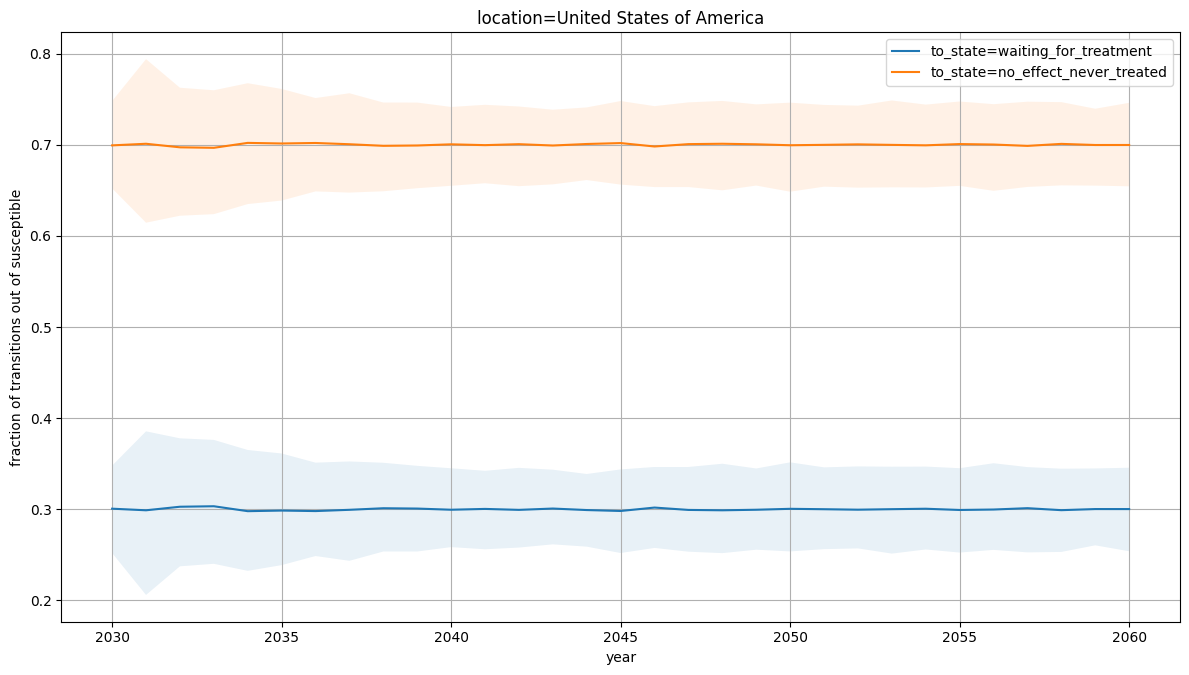

In [42]:
fig = plot_over_time_by_column_for_row_x_1(
    initiate_vs_not,
    'to_state',
    'location',
    ylabel='fraction of transitions out of susceptible',
)
for ax in fig.axes:
    # Looks like this is unnecessary after converting year to int
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)

# Check #2 (completes vs. discontinues treatment)

10% of transitions to Full treatment effect status are by simulants who
discontinue treatment

## Looks good

In [43]:
treatment_transitions.from_state.unique()

['waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'susceptible_to_treatment']
Categories (6, object): ['full_effect_long', 'full_effect_short', 'susceptible_to_treatment', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [44]:
# This gives the fraction of the total transitions out of
# 'waiting_for_treatment' that go to 'full_effect_long' vs.
# 'full_effect_short'. These ratios should be 0.9 and 0.1, respectively,
# across locations, age groups, draws, etc.
complete_vs_discontinue = ops.ratio(
    treatment_transitions,
    treatment_transitions,
    strata=[],
    prefilter_query="from_state == 'waiting_for_treatment'",
    numerator_broadcast=['to_state'],
    # denominator_broadcast=['to_state'],
)
complete_vs_discontinue

,random_seed,scenario,location,to_state,value,numerator_measure,denominator_measure,multiplier
0,17,bbbm_testing_and_treatment,United States of America,full_effect_long,0.899704,transition_count,transition_count,1
1,17,bbbm_testing_and_treatment,United States of America,full_effect_short,0.100296,transition_count,transition_count,1
2,28,bbbm_testing_and_treatment,United States of America,full_effect_long,0.903768,transition_count,transition_count,1
3,28,bbbm_testing_and_treatment,United States of America,full_effect_short,0.096232,transition_count,transition_count,1
4,40,bbbm_testing_and_treatment,United States of America,full_effect_long,0.901653,transition_count,transition_count,1
...,...,...,...,...,...,...,...,...
995,9961,bbbm_testing_and_treatment,United States of America,full_effect_short,0.106864,transition_count,transition_count,1
996,9969,bbbm_testing_and_treatment,United States of America,full_effect_long,0.895285,transition_count,transition_count,1
997,9969,bbbm_testing_and_treatment,United States of America,full_effect_short,0.104715,transition_count,transition_count,1
998,9971,bbbm_testing_and_treatment,United States of America,full_effect_long,0.904324,transition_count,transition_count,1


In [45]:
# Draw 2 in Japan: ratio of fraction of transitions to full_effect_long
# to fraction of transitions to full_effect short (rowss 0 and 1 above),
# gives the same value as the row for draw 2 in Japan in the table
# below:
# 8	2	bbbm_testing_and_treatment	Japan	8.956227	transition_count	transition_count	1
0.899560 / 0.100440

8.956192751891678

In [46]:
# This gives the ratio of the total transitions from start -> long to
# start -> short. The ratio should be approximately 9.0 for all
# locations, draws, age groups, etc. These ratios are equivalent to
# dividing the 'full_effect_long' rows in the previous dataframe by the
# 'full_effect_short' rows (see above cell for an example).
complete_to_discontinue_ratio = ops.ratio(
    treatment_transitions.query("to_state == 'full_effect_long'"),
    treatment_transitions.query("to_state == 'full_effect_short'"),
    strata=[],
    prefilter_query="from_state == 'waiting_for_treatment'",
    # numerator_broadcast=['to_state'],
    # denominator_broadcast=['to_state'],
)
complete_to_discontinue_ratio

,random_seed,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,2047,bbbm_testing_and_treatment,United States of America,9.553977,transition_count,transition_count,1
1,6810,bbbm_testing_and_treatment,United States of America,8.986702,transition_count,transition_count,1
2,4622,bbbm_testing_and_treatment,United States of America,8.518610,transition_count,transition_count,1
3,1209,bbbm_testing_and_treatment,United States of America,9.538889,transition_count,transition_count,1
4,9449,bbbm_testing_and_treatment,United States of America,9.857542,transition_count,transition_count,1
...,...,...,...,...,...,...,...
495,3093,bbbm_testing_and_treatment,United States of America,8.670951,transition_count,transition_count,1
496,9584,bbbm_testing_and_treatment,United States of America,8.586294,transition_count,transition_count,1
497,8610,bbbm_testing_and_treatment,United States of America,8.032941,transition_count,transition_count,1
498,9450,bbbm_testing_and_treatment,United States of America,8.521303,transition_count,transition_count,1


In [47]:
# NOTE: ops.describe explicitly calculates uncertainty over
# ops.draw_col, so setting the draw column to 'random_seed' makes this
# work. Another option would be to allow passing in the "uncertainty"
# column instead of always assuming it's the input draw.
summarize_sim_data(complete_to_discontinue_ratio)

,,,,,count,mean,std,min,lower,50%,upper,max
denominator_measure,location,multiplier,numerator_measure,scenario,,,,,,,,
transition_count,United States of America,1,transition_count,bbbm_testing_and_treatment,500.0,9.037907,0.477061,7.909953,8.15139,9.038655,10.013714,10.569231


In [48]:
summarize_sim_data(complete_vs_discontinue)

count  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                   
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   500.0   
                                                                                                     full_effect_short  500.0   

                                                                                                                            mean  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.900154   
                                                                                                     full_effect_short  0.099846   

                                                                                                                             std  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.004733   
                                                                                                     full_effect_short  0.004733   

                                                                                                                             min  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.887766   
                                                                                                     full_effect_short  0.086436   

                                                                                                                           lower  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.890727   
                                                                                                     full_effect_short  0.090796   

                                                                                                                             50%  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.900385   
                                                                                                     full_effect_short  0.099615   

                                                                                                                           upper  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.909204   
                                                                                                     full_effect_short  0.109273   

                                                                                                                             max  
denominator_measure location                 multiplier numerator_measure scenario                   to_state                     
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.913564  
                                    

# Check #3 (durations of full vs. waning treatment)

Full/Waning durations are accurate (use person-time ratios between
states?)

## Strategy

Look at ratio of person-time in each state to the person-time in the
`'waiting_for_treatment'` state. Using the fact that 90% of simulants complete
treatment and end up in the "long" states, while 10% of simulants
discontinue treatment and end up in the "short" states, we can predict
what these ratios should be.

## Results

Things look good except for the `'waning_effect_long'` state, whose
ratio to the `'waiting_for_treatment'` state looks too low (it's the same as
for the `'full_effect_long'` state).

In [49]:
all_tx_states = person_time_treatment.sub_entity.unique()
all_tx_states

['susceptible_to_treatment', 'waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']
Categories (9, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', ..., 'susceptible_to_treatment', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [50]:
no_effect_states = [state for state in all_tx_states if 'no_effect' in state]
no_effect_states

['no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']

In [51]:
# Compute ratio of person-time in each state to the person-time in the
# "waiting_for_treatment" state
tx_person_time_ratios = ops.ratio(
    person_time_treatment,
    person_time_treatment.query("sub_entity == 'waiting_for_treatment'"),
    strata=['event_year'],
    prefilter_query=(
        "scenario == 'bbbm_testing_and_treatment'"
        f" and event_year >= 2030" #" and age_group in {treatment_eligible_age_groups}"
        f" and sub_entity not in {no_effect_states + ['susceptible_to_treatment']}"
    ),
    numerator_broadcast=['sub_entity'],
)
tx_person_time_ratios

,event_year,random_seed,scenario,location,sub_entity,value,numerator_measure,denominator_measure,multiplier
0,2030,17,bbbm_testing_and_treatment,United States of America,waiting_for_treatment,1.000000,person_time,person_time,1
1,2030,17,bbbm_testing_and_treatment,United States of America,full_effect_long,0.000000,person_time,person_time,1
2,2030,17,bbbm_testing_and_treatment,United States of America,full_effect_short,0.000000,person_time,person_time,1
3,2030,17,bbbm_testing_and_treatment,United States of America,waning_effect_long,0.000000,person_time,person_time,1
4,2030,17,bbbm_testing_and_treatment,United States of America,waning_effect_short,0.000000,person_time,person_time,1
...,...,...,...,...,...,...,...,...,...
77495,2060,9971,bbbm_testing_and_treatment,United States of America,waiting_for_treatment,1.000000,person_time,person_time,1
77496,2060,9971,bbbm_testing_and_treatment,United States of America,full_effect_long,7.596026,person_time,person_time,1
77497,2060,9971,bbbm_testing_and_treatment,United States of America,full_effect_short,0.132450,person_time,person_time,1
77498,2060,9971,bbbm_testing_and_treatment,United States of America,waning_effect_long,9.456954,person_time,person_time,1


In [52]:
tx_state_durations = pd.DataFrame(
    {
        # Durations from state diagram in treatment documentation
        'duration': [0.5, 5.0, 0.5, 9.0, 2.5],
        # 90% of people complete treatment and get long treatment
        # effect, 10% discontinue and get short treatment effect 
        'population_fraction': [1, 0.9, 0.1, 0.9, 0.1],
    },
    index=pd.CategoricalIndex(
        ['waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short'],
        name='sub_entity',
    )
)
# Compute the ratio of the population-weighted duration of each state to
# the duration of the "start treatment" state.
tx_state_durations['target_person_time_ratio'] = (
    tx_state_durations['duration'] * tx_state_durations['population_fraction']
    / tx_state_durations.at['waiting_for_treatment', 'duration']
)
tx_state_durations


,duration,population_fraction,target_person_time_ratio
sub_entity,,,
waiting_for_treatment,0.5,1.0,1.0
full_effect_long,5.0,0.9,9.0
full_effect_short,0.5,0.1,0.1
waning_effect_long,9.0,0.9,16.2
waning_effect_short,2.5,0.1,0.5


In [53]:
# For posting in Slack...
print(tx_state_durations.rename(
    columns={'population_fraction': 'pop_frac', 'target_person_time_ratio': 'pt_ratio'}))

                       duration  pop_frac  pt_ratio
sub_entity                                         
waiting_for_treatment       0.5       1.0       1.0
full_effect_long            5.0       0.9       9.0
full_effect_short           0.5       0.1       0.1
waning_effect_long          9.0       0.9      16.2
waning_effect_short         2.5       0.1       0.5


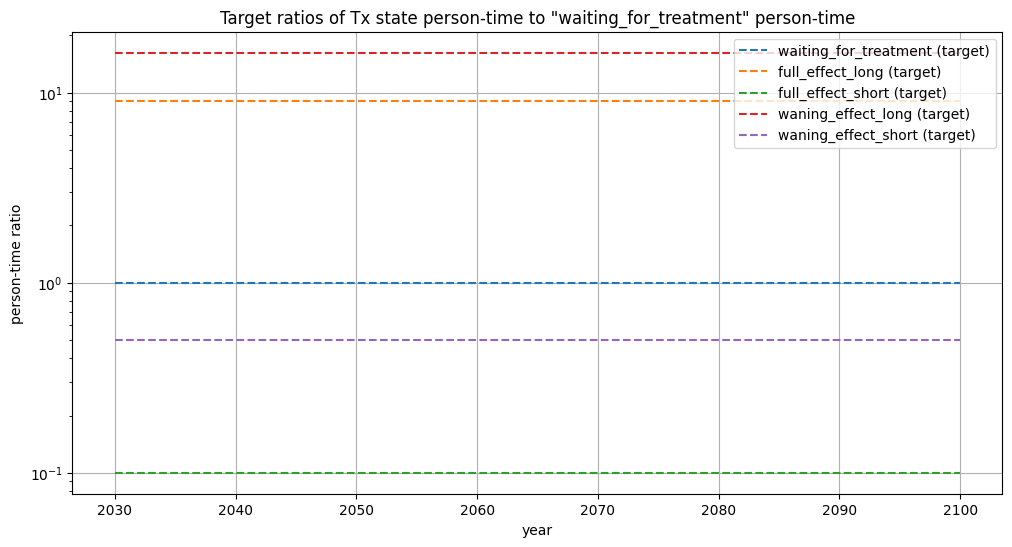

In [54]:
def plot_treatment_state_targets(tx_state_durations, column, ax):
    """Plot horizontal lines for values in one column of the treatment
    state durations table.
    """
    existing_lines = ax.get_lines()
    if len(existing_lines) == 0:
        # Axes.hlines plots all lines in a single color by default, so if you
        # want different colors, you have to explicitly cycle through them 
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']

    for i, state in enumerate(tx_state_durations.index):
        # Find color corresponding to state if there already exists a
        # line for that state
        for line in existing_lines:
            if state in line.get_label():
                color = line.get_color()
                break
        # If there were no existing lines, go to next color in cycle
        if len(existing_lines) == 0:
            color = colors[i % len(colors)]
        ax.hlines(tx_state_durations.at[state, column], 2030, 2100, color, '--', label=f'{state} (target)')
    return ax

fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'target_person_time_ratio', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target ratios of Tx state person-time to "waiting_for_treatment" person-time',
)
ax.grid(True)
ax.legend()
ax.semilogy()
plt.show()

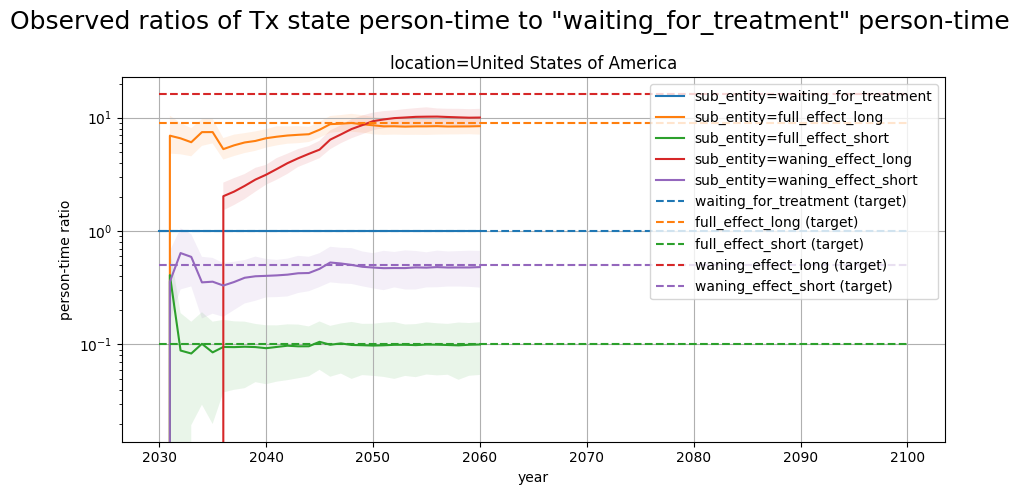

In [55]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_person_time_ratios,
    'sub_entity',
    'location',
    ylabel='person-time ratio',
    suptitle='Observed ratios of Tx state person-time to "waiting_for_treatment" person-time',
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'target_person_time_ratio', ax)
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
    ax.legend()
    ax.semilogy()
plt.show()

In [56]:
tx_person_time_ratios.groupby(['event_year', 'sub_entity'])['value'].describe()

count       mean       std       min  \
event_year sub_entity                                                    
2030       full_effect_long       500.0   0.000000  0.000000  0.000000   
           full_effect_short      500.0   0.000000  0.000000  0.000000   
           waiting_for_treatment  500.0   1.000000  0.000000  1.000000   
           waning_effect_long     500.0   0.000000  0.000000  0.000000   
           waning_effect_short    500.0   0.000000  0.000000  0.000000   
...                                 ...        ...       ...       ...   
2060       full_effect_long       500.0   8.417598  0.759560  6.794444   
           full_effect_short      500.0   0.099899  0.027240  0.039735   
           waiting_for_treatment  500.0   1.000000  0.000000  1.000000   
           waning_effect_long     500.0  10.022047  0.912523  7.887500   
           waning_effect_short    500.0   0.480798  0.089470  0.270440   

                                       25%       50%        75%        max  
event_year sub_entity                                                       
2030       full_effect_long       0.000000  0.000000   0.000000   0.000000  
           full_effect_short      0.000000  0.000000   0.000000   0.000000  
           waiting_for_treatment  1.000000  1.000000   1.000000   1.000000  
           waning_effect_long     0.000000  0.000000   0.000000   0.000000  
           waning_effect_short    0.000000  0.000000   0.000000   0.000000  
...                                    ...       ...        ...        ...  
2060       full_effect_long       7.869264  8.398601   8.910621  10.821429  
           full_effect_short      0.079137  0.097482   0.117252   0.187919  
           waiting_for_treatment  1.000000  1.000000   1.000000   1.000000  
           waning_effect_long     9.380137  9.938940  10.565605  13.526786  
           waning_effect_short    0.422135  0.478101   0.530594   0.830357  

[155 rows x 8 columns]

## Check values

In [57]:
tx_person_time_ratios.query("sub_entity == 'waning_effect_long' and event_year>2060").value.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: value, dtype: float64

In [58]:
tx_person_time_ratios.query("sub_entity == 'full_effect_long' and event_year>2060").value.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: value, dtype: float64

In [59]:
# Compute implied durations from the ratios above
# Target durations are (9, 5)
12.576105 / .9 * .5, 8.641488 / .9 * .5

(6.986725, 4.800826666666667)

In [60]:
ops.index_cols

['random_seed', 'scenario', 'location']

## Look at actual person-time instead of the ratio

In [61]:
ops.describe(
    ops.stratify(
        person_time_treatment.query(
            "value > 0 and "
            "(sub_entity == 'waiting_for_treatment' or "
            " sub_entity.str.endswith('effect_long')) and event_year > 2050"
            # " and location == 'Spain'"
        ),
        ['event_year', 'sub_entity']
    )
)

count  \
event_year location                 scenario                   sub_entity                     
2051       United States of America bbbm_testing_and_treatment full_effect_long       500.0   
                                                               waiting_for_treatment  500.0   
                                                               waning_effect_long     500.0   
2052       United States of America bbbm_testing_and_treatment full_effect_long       500.0   
                                                               waiting_for_treatment  500.0   
                                                               waning_effect_long     500.0   
2053       United States of America bbbm_testing_and_treatment full_effect_long       500.0   
                                                               waiting_for_treatment  500.0   
                                                               waning_effect_long     500.0   
2054       United States of America bbbm_testing_and_treatment full_effect_long       500.0   
                                                               waiting_for_treatment  500.0   
                                                               waning_effect_long     500.0   
2055       United States of America bbbm_testing_and_treatment full_effect_long       500.0   
                                                               waiting_for_treatment  500.0   
                                                               waning_effect_long     500.0   
2056       United States of America bbbm_testing_and_treatment full_effect_long       500.0   
                                                               waiting_for_treatment  500.0   
                                                               waning_effect_long     500.0   
2057       United States of America bbbm_testing_and_treatment full_effect_long       500.0   
                                                               waiting_for_treatment  500.0   
                                                               waning_effect_long     500.0   
2058       United States of America bbbm_testing_and_treatment full_effect_long       500.0   
                                                               waiting_for_treatment  500.0   
                                                               waning_effect_long     500.0   
2059       United States of America bbbm_testing_and_treatment full_effect_long       500.0   
                                                               waiting_for_treatment  500.0   
                                                               waning_effect_long     500.0   
2060       United States of America bbbm_testing_and_treatment full_effect_long       500.0   
                                                               waiting_for_treatment  500.0   
                                                               waning_effect_long     500.0   

                                                                                            mean  \
event_year location                 scenario                   sub_entity                          
2051       United States of America bbbm_testing_and_treatment full_effect_long       596.322190   
                                                               waiting_for_treatment   71.575206   
                                                               waning_effect_long     685.477027   
2052       United States of America bbbm_testing_and_treatment full_effect_long       595.151211   
                                                               waiting_for_treatment   71.364928   
                                                               waning_effect_long     702.884249   
2053       United States of America bbbm_testing_and_treatment full_effect_long       594.551272   
                                                               waiting_for_treatment   71.814385   
                                             

In [62]:
9721.296427 / 1129.481287

8.606868071998433

In [63]:
13995.099904 / 1129.481287

12.390731980316554

# Check #4 (duration of start treatment/waiting for treatment)

“In treatment/waiting for treatment” duration is accurate (use
person-time ratios between states?)

This duration is supposed to be 6 months for all simulants.

## Strategy

To compute the average duration of each state, divide the total
person-time of that state by the number of simulants entering that
state, i.e., the the sum of transition counts where it's the `to_state`.

Alternatively, compute the average duration by dividing the total
person-time by the number of simulants *exiting* the state, i.e., the
sum of transition counts where it's the `from_state`.

## Results

I'm not sure how closely either of these strategies should match the
actual duration... Neither takes deaths into account, and I stratified
the calculations by year, which seems weird because some of the
durations are much longer than a year.

Nevertheless, the observed average durations for 4 out of 5 of the
states eventually converge to a value pretty close to the specified
duration, using either of the above two methods. The fifth state,
`'waning_effect_long'`, converges to different values in each of the
above two methods, neither of which is particularly close to the target
duration of 9 years. We think this is probably due to mortality.

In [64]:
person_time_treatment

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,artifact_path,scenario,input_draw,random_seed,value,location
0,person_time,cause,treatment,susceptible_to_treatment,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
1,person_time,cause,treatment,waiting_for_treatment,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
2,person_time,cause,treatment,full_effect_long,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
3,person_time,cause,treatment,full_effect_short,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
4,person_time,cause,treatment,waning_effect_long,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719995,person_time,cause,treatment,waning_effect_long,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.000000,United States of America
9719996,person_time,cause,treatment,waning_effect_short,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.000000,United States of America
9719997,person_time,cause,treatment,no_effect_after_long,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,9.965777,United States of America
9719998,person_time,cause,treatment,no_effect_after_short,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.000000,United States of America


In [65]:
treatment_transitions.query("value>0")

,age_group,artifact_path,entity,entity_type,event_year,input_draw,location,measure,random_seed,scenario,sex,sub_entity,value,from_state,to_state
2056000,60_to_64,/homes/abie/projects/2025/vivarium_csu_alzheim...,treatment,cause,2030,457,United States of America,transition_count,2047,bbbm_testing_and_treatment,Female,waiting_for_treatment_to_full_effect_long,2.0,waiting_for_treatment,full_effect_long
2056006,60_to_64,/homes/abie/projects/2025/vivarium_csu_alzheim...,treatment,cause,2030,457,United States of America,transition_count,2047,bbbm_testing_and_treatment,Female,susceptible_to_treatment_to_waiting_for_treatment,2.0,susceptible_to_treatment,waiting_for_treatment
2056007,60_to_64,/homes/abie/projects/2025/vivarium_csu_alzheim...,treatment,cause,2030,457,United States of America,transition_count,2047,bbbm_testing_and_treatment,Female,susceptible_to_treatment_to_no_effect_never_tr...,9.0,susceptible_to_treatment,no_effect_never_treated
2056008,60_to_64,/homes/abie/projects/2025/vivarium_csu_alzheim...,treatment,cause,2030,457,United States of America,transition_count,2047,bbbm_testing_and_treatment,Male,waiting_for_treatment_to_full_effect_long,2.0,waiting_for_treatment,full_effect_long
2056009,60_to_64,/homes/abie/projects/2025/vivarium_csu_alzheim...,treatment,cause,2030,457,United States of America,transition_count,2047,bbbm_testing_and_treatment,Male,waiting_for_treatment_to_full_effect_short,1.0,waiting_for_treatment,full_effect_short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4031964,90_to_94,/homes/abie/projects/2025/vivarium_csu_alzheim...,treatment,cause,2060,457,United States of America,transition_count,8610,bbbm_testing_and_treatment,Male,waning_effect_long_to_no_effect_after_long,4.0,waning_effect_long,no_effect_after_long
4031972,90_to_94,/homes/abie/projects/2025/vivarium_csu_alzheim...,treatment,cause,2060,457,United States of America,transition_count,9450,bbbm_testing_and_treatment,Female,waning_effect_long_to_no_effect_after_long,12.0,waning_effect_long,no_effect_after_long
4031980,90_to_94,/homes/abie/projects/2025/vivarium_csu_alzheim...,treatment,cause,2060,457,United States of America,transition_count,9450,bbbm_testing_and_treatment,Male,waning_effect_long_to_no_effect_after_long,4.0,waning_effect_long,no_effect_after_long
4031988,90_to_94,/homes/abie/projects/2025/vivarium_csu_alzheim...,treatment,cause,2060,457,United States of America,transition_count,3528,bbbm_testing_and_treatment,Female,waning_effect_long_to_no_effect_after_long,9.0,waning_effect_long,no_effect_after_long


In [66]:
tx_state_mean_durations_incoming = ops.ratio(
    person_time_treatment.assign(to_state=lambda df: df['sub_entity']),
    treatment_transitions.query("value>0"),
    strata=['event_year', 'to_state'],
    prefilter_query=(
        "scenario=='bbbm_testing_and_treatment' and event_year >= 2030"
    )
)
tx_state_mean_durations_incoming

,event_year,to_state,random_seed,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,2030,full_effect_long,17,bbbm_testing_and_treatment,United States of America,0.000000,person_time,transition_count,1
1,2030,full_effect_long,28,bbbm_testing_and_treatment,United States of America,0.000000,person_time,transition_count,1
2,2030,full_effect_long,40,bbbm_testing_and_treatment,United States of America,0.000000,person_time,transition_count,1
3,2030,full_effect_long,93,bbbm_testing_and_treatment,United States of America,0.000000,person_time,transition_count,1
4,2030,full_effect_long,99,bbbm_testing_and_treatment,United States of America,0.000000,person_time,transition_count,1
...,...,...,...,...,...,...,...,...,...
139495,2060,waning_effect_short,9914,bbbm_testing_and_treatment,United States of America,2.709446,person_time,transition_count,1
139496,2060,waning_effect_short,9947,bbbm_testing_and_treatment,United States of America,2.292129,person_time,transition_count,1
139497,2060,waning_effect_short,9961,bbbm_testing_and_treatment,United States of America,2.171116,person_time,transition_count,1
139498,2060,waning_effect_short,9969,bbbm_testing_and_treatment,United States of America,4.872158,person_time,transition_count,1


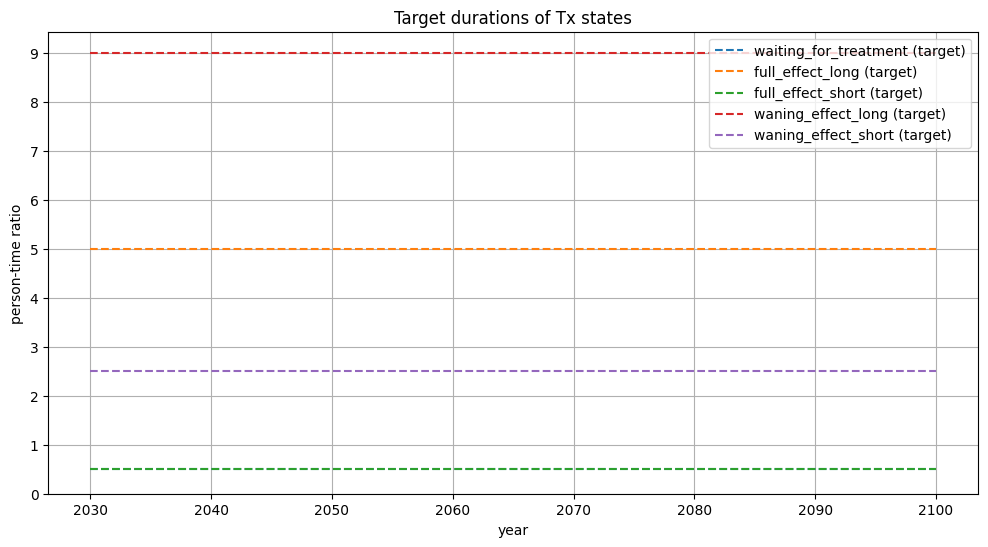

In [67]:
fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target durations of Tx states',
)
ax.grid(True)
ax.legend()
ax.set(yticks=range(0,10))
# ax.semilogy()
plt.show()

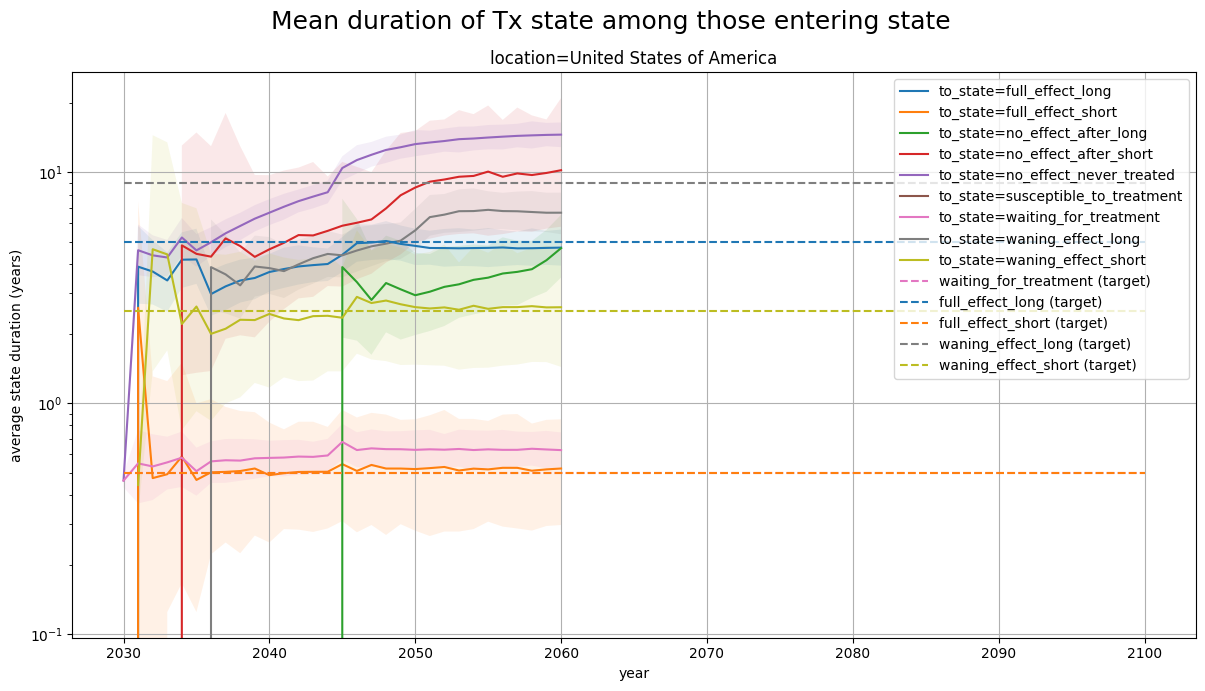

In [68]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_state_mean_durations_incoming,
    'to_state',
    'location',
    ylabel='average state duration (years)',
    suptitle="Mean duration of Tx state among those entering state",
    # axes_width=9,
    # axes_height=4,
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
    ax.legend()
    ax.grid(True)
    ax.semilogy()
plt.show()

In [69]:
tx_state_mean_durations_outgoing = ops.ratio(
    person_time_treatment.assign(from_state=lambda df: df['sub_entity']),
    treatment_transitions.query("value>0"),
    strata=['event_year', 'from_state'],
    prefilter_query=(
        "scenario=='bbbm_testing_and_treatment' and event_year >= 2030"
    )
)
tx_state_mean_durations_outgoing

,event_year,from_state,random_seed,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,2030,full_effect_long,17,bbbm_testing_and_treatment,United States of America,NaN,person_time,transition_count,1
1,2030,full_effect_long,28,bbbm_testing_and_treatment,United States of America,NaN,person_time,transition_count,1
2,2030,full_effect_long,40,bbbm_testing_and_treatment,United States of America,NaN,person_time,transition_count,1
3,2030,full_effect_long,93,bbbm_testing_and_treatment,United States of America,NaN,person_time,transition_count,1
4,2030,full_effect_long,99,bbbm_testing_and_treatment,United States of America,NaN,person_time,transition_count,1
...,...,...,...,...,...,...,...,...,...
139495,2060,waning_effect_short,9914,bbbm_testing_and_treatment,United States of America,4.335113,person_time,transition_count,1
139496,2060,waning_effect_short,9947,bbbm_testing_and_treatment,United States of America,2.292129,person_time,transition_count,1
139497,2060,waning_effect_short,9961,bbbm_testing_and_treatment,United States of America,1.787978,person_time,transition_count,1
139498,2060,waning_effect_short,9969,bbbm_testing_and_treatment,United States of America,2.436079,person_time,transition_count,1


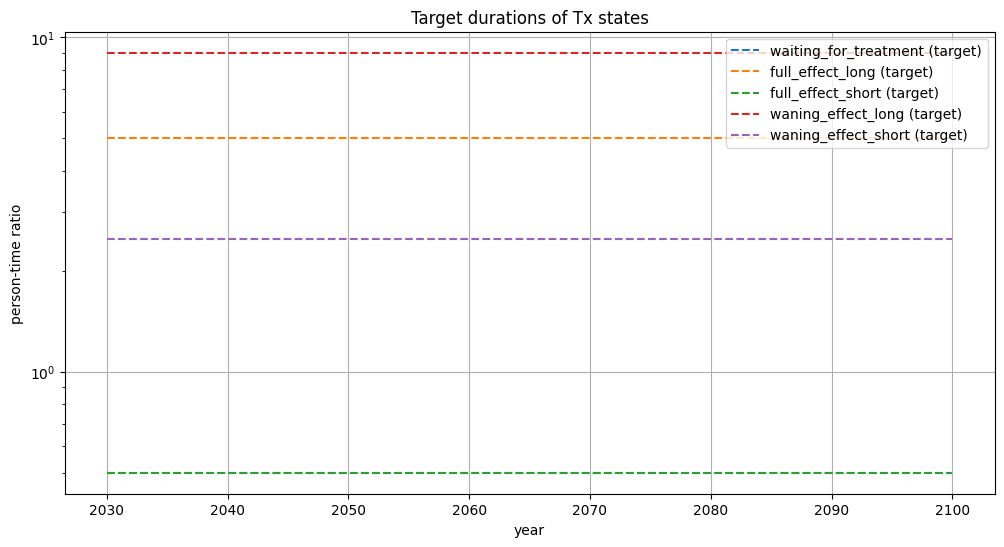

In [70]:
fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target durations of Tx states',
)
ax.grid(True)
ax.legend()
ax.set(yticks=range(0,10))
ax.semilogy()
plt.show()

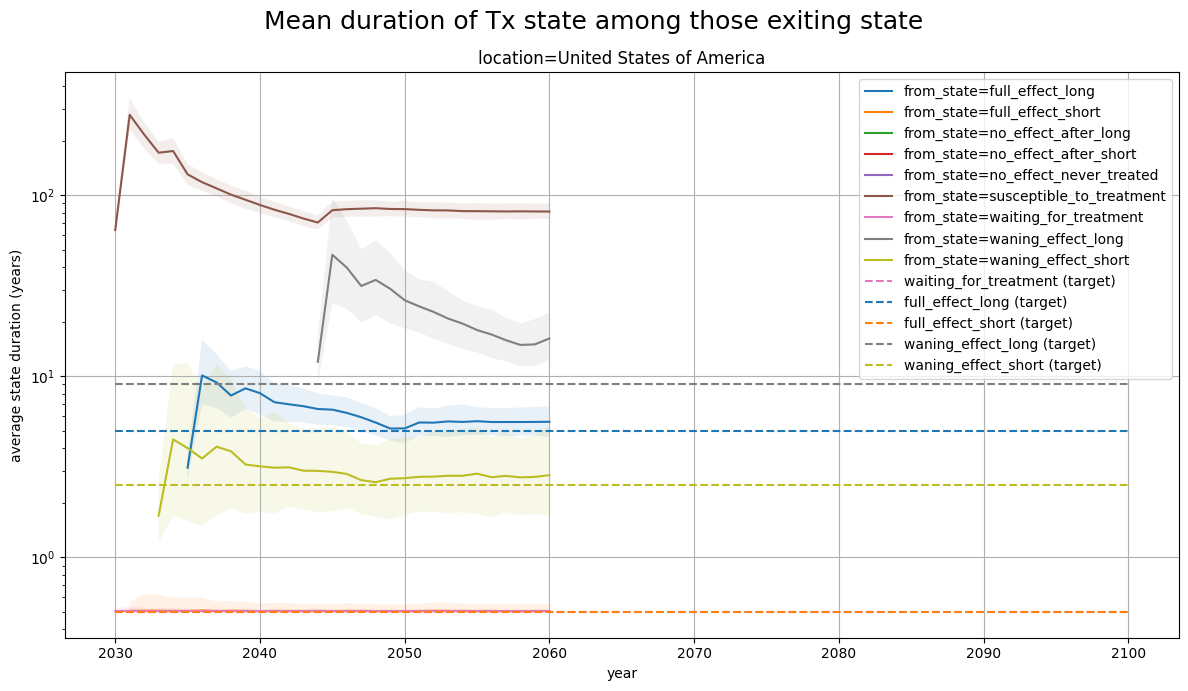

In [71]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_state_mean_durations_outgoing,
    'from_state',
    'location',
    ylabel='average state duration (years)',
    suptitle="Mean duration of Tx state among those exiting state",
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
    ax.legend()
    ax.grid(True)
    ax.semilogy()
plt.show()

## Check value of `waning_effect_long`

It's not close to 9 years in either graph.

In [72]:
tx_state_mean_durations_incoming.query("to_state == 'waning_effect_long' and event_year > 2050").value.describe()

count    5000.000000
mean        6.697207
std         0.706164
min         4.461346
25%         6.191780
50%         6.647076
75%         7.133729
max        10.464066
Name: value, dtype: float64

In [73]:
tx_state_mean_durations_outgoing.query("from_state == 'waning_effect_long' and event_year > 2050").value.describe()

count    5000.000000
mean       18.399099
std         4.468619
min        10.258423
25%        15.166328
50%        17.485935
75%        20.773281
max        47.902167
Name: value, dtype: float64

## By contrast, check the value of `full_effect_long`

It **is** close to 5 years in _both_ graphs.

In [74]:
tx_state_mean_durations_incoming.query("to_state == 'full_effect_long' and event_year > 2050").value.describe()

count    5000.000000
mean        4.694718
std         0.442665
min         3.456284
25%         4.380712
50%         4.658803
75%         4.969418
max         6.713505
Name: value, dtype: float64

In [75]:
tx_state_mean_durations_outgoing.query("from_state == 'full_effect_long' and event_year > 2050").value.describe()

count    5000.000000
mean        5.586831
std         0.527009
min         3.989771
25%         5.222888
50%         5.542891
75%         5.897274
max         8.091930
Name: value, dtype: float64

# Check #5 (Interactive sim)

I'm planning to do the interactive sim in another notebook.

# Check #6 (hazard ratio)

Check hazard ratios for simulants who begin treatment and those who
transition to *No treatment effect* (Check hazard ratio of treated to
not treated for hazard rate from BBBM to MCI)

## I think I can't check this in the outputs because neither cause transitions nor cause state person-time is stratified by treatment status

In [76]:
person_time_cause_states = load_sim_output(
    'person_time_alzheimers_disease_and_other_dementias',
    aggregate_seeds=False,
)
print_memory_usage(person_time_cause_states)
person_time_cause_states

670.705243 MB


,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,scenario,input_draw,random_seed,value,location
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,susceptible_to_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waiting_for_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29159995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.000000,United States of America
29159996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.000000,United States of America
29159997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,7.474333,United States of America
29159998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.000000,United States of America


In [77]:
person_time_cause_states.dtypes

measure          category
entity_type      category
entity           category
sub_entity       category
age_group        category
event_year          int16
sex              category
treatment        category
artifact_path    category
scenario         category
input_draw       category
random_seed      category
value             float64
location         category
dtype: object

In [78]:
person_time_cause_states.treatment.unique()

['susceptible_to_treatment', 'waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']
Categories (9, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', ..., 'susceptible_to_treatment', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [79]:
person_time_cause_states.sub_entity.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state', 'alzheimers_disease_state']
Categories (3, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_disease_state', 'alzheimers_mild_cognitive_impairment_state']

In [80]:
transition_count_cause_states = (
    load_sim_output(
        'transition_count_alzheimers_disease_and_other_dementias',
        aggregate_seeds=False,
    )
    # Display memory usage of loaded dataframe before adding columns
    .pipe(lambda df: print_memory_usage(df) or df)
    # Add columns for from and to state
    .pipe(lambda df: df.join(
        cleaning.extract_transition_states(df, 'sub_entity'))
    )
    # Display memory usage of loaded dataframe after adding columns
    .pipe(lambda df: print_memory_usage(df) or df)
    # Convert the new columns to Categoricals
    .pipe(convert_to_categorical)
)
print_memory_usage(transition_count_cause_states)
transition_count_cause_states

447.145241 MB
4082.425241 MB
466.587191 MB


,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,scenario,input_draw,random_seed,value,location,from_state,to_state
0,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state_to_alzh...,25_to_29,2025,Female,susceptible_to_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America,alzheimers_blood_based_biomarker_state,alzheimers_mild_cognitive_impairment_state
1,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state_to_alzh...,25_to_29,2025,Female,waiting_for_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America,alzheimers_blood_based_biomarker_state,alzheimers_mild_cognitive_impairment_state
2,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state_to_alzh...,25_to_29,2025,Female,full_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America,alzheimers_blood_based_biomarker_state,alzheimers_mild_cognitive_impairment_state
3,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state_to_alzh...,25_to_29,2025,Female,full_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America,alzheimers_blood_based_biomarker_state,alzheimers_mild_cognitive_impairment_state
4,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state_to_alzh...,25_to_29,2025,Female,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America,alzheimers_blood_based_biomarker_state,alzheimers_mild_cognitive_impairment_state
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19439995,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2060,Male,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.0,United States of America,alzheimers_mild_cognitive_impairment_state,alzheimers_disease_state
19439996,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2060,Male,waning_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.0,United States of America,alzheimers_mild_cognitive_impairment_state,alzheimers_disease_state
19439997,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2060,Male,no_effect_after_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,2.0,United States of America,alzheimers_mild_cognitive_impairment_state,alzheimers_disease_state
19439998,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2060,Male,no_effect_after_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.0,United States of America,alzheimers_mild_cognitive_impairment_state,alzheimers_disease_state


In [81]:
transition_count_cause_states.dtypes

measure          category
entity_type      category
entity           category
sub_entity       category
age_group        category
event_year       category
sex              category
treatment        category
artifact_path    category
scenario         category
input_draw       category
random_seed      category
value             float64
location         category
from_state       category
to_state         category
dtype: object

In [82]:
transition_count_cause_states.from_state.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state']
Categories (2, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state']

In [83]:
incidence_rates_by_treatment = ops.ratio(
    transition_count_cause_states,
    person_time_cause_states.rename(columns={'sub_entity': 'from_state'}),
    strata=['event_year', 'from_state', 'treatment'],
    numerator_broadcast='to_state', # doesn't actually broadcast, just records it
    measure='transition_rate',
    dropna=True,
)
incidence_rates_by_treatment

,event_year,from_state,treatment,random_seed,scenario,location,to_state,value,measure,numerator_measure,denominator_measure,multiplier
0,2025,alzheimers_blood_based_biomarker_state,susceptible_to_treatment,17,baseline,United States of America,alzheimers_mild_cognitive_impairment_state,0.145797,transition_rate,transition_count,person_time,1
1,2025,alzheimers_blood_based_biomarker_state,susceptible_to_treatment,17,bbbm_testing_and_treatment,United States of America,alzheimers_mild_cognitive_impairment_state,0.145797,transition_rate,transition_count,person_time,1
2,2025,alzheimers_blood_based_biomarker_state,susceptible_to_treatment,28,baseline,United States of America,alzheimers_mild_cognitive_impairment_state,0.139052,transition_rate,transition_count,person_time,1
3,2025,alzheimers_blood_based_biomarker_state,susceptible_to_treatment,28,bbbm_testing_and_treatment,United States of America,alzheimers_mild_cognitive_impairment_state,0.139052,transition_rate,transition_count,person_time,1
4,2025,alzheimers_blood_based_biomarker_state,susceptible_to_treatment,40,baseline,United States of America,alzheimers_mild_cognitive_impairment_state,0.141535,transition_rate,transition_count,person_time,1
...,...,...,...,...,...,...,...,...,...,...,...,...
271525,2060,alzheimers_mild_cognitive_impairment_state,waning_effect_short,9914,bbbm_testing_and_treatment,United States of America,alzheimers_disease_state,0.000000,transition_rate,transition_count,person_time,1
271526,2060,alzheimers_mild_cognitive_impairment_state,waning_effect_short,9947,bbbm_testing_and_treatment,United States of America,alzheimers_disease_state,0.222985,transition_rate,transition_count,person_time,1
271527,2060,alzheimers_mild_cognitive_impairment_state,waning_effect_short,9961,bbbm_testing_and_treatment,United States of America,alzheimers_disease_state,0.000000,transition_rate,transition_count,person_time,1
271528,2060,alzheimers_mild_cognitive_impairment_state,waning_effect_short,9969,bbbm_testing_and_treatment,United States of America,alzheimers_disease_state,0.602060,transition_rate,transition_count,person_time,1


## Investigate infinite transition rates between disease states

My plotting code below initially failed with `FloatingPointError:
invalid value encountered in subtract` in the `lower` function, due to
infinities in the transition rates data.

According to the engineers, we may be getting 0 person-time in some
strata where counts are nonzero because person-time is recorded at the
beginning of a time step, while transition counts are recorded at the
end. So for example, if someone starts in preclinical, in the "waiting
for treatment" state, then transitions to MCI and to "full effect long"
on the same time step, then they would have their person-time recorded
in the (preclinical, waiting for treatment) stratum, but their disease
transition recorded in the (preclinical- > MCI, full effect long)
stratum.

The engineers said there was a bugfix in model 7.2 that *might* address
this problem, so I'll try this again there...

In [84]:
incidence_rates_by_treatment.value.describe()

count    2.715300e+05
mean              inf
std               NaN
min      0.000000e+00
25%      1.157809e-01
50%      1.652715e-01
75%      2.524496e-01
max               inf
Name: value, dtype: float64

In [85]:
inf = np.isinf(incidence_rates_by_treatment.value)
print(inf.sum(), "rows with infinite values")
incidence_rates_by_treatment.loc[inf]#.query("from_state=='alzheimers_blood_based_biomarker_state'")

2687 rows with infinite values


,event_year,from_state,treatment,random_seed,scenario,location,to_state,value,measure,numerator_measure,denominator_measure,multiplier
10000,2030,alzheimers_blood_based_biomarker_state,full_effect_long,17,bbbm_testing_and_treatment,United States of America,alzheimers_mild_cognitive_impairment_state,inf,transition_rate,transition_count,person_time,1
10001,2030,alzheimers_blood_based_biomarker_state,full_effect_long,28,bbbm_testing_and_treatment,United States of America,alzheimers_mild_cognitive_impairment_state,inf,transition_rate,transition_count,person_time,1
10002,2030,alzheimers_blood_based_biomarker_state,full_effect_long,40,bbbm_testing_and_treatment,United States of America,alzheimers_mild_cognitive_impairment_state,inf,transition_rate,transition_count,person_time,1
10003,2030,alzheimers_blood_based_biomarker_state,full_effect_long,93,bbbm_testing_and_treatment,United States of America,alzheimers_mild_cognitive_impairment_state,inf,transition_rate,transition_count,person_time,1
10004,2030,alzheimers_blood_based_biomarker_state,full_effect_long,99,bbbm_testing_and_treatment,United States of America,alzheimers_mild_cognitive_impairment_state,inf,transition_rate,transition_count,person_time,1
...,...,...,...,...,...,...,...,...,...,...,...,...
119685,2044,alzheimers_mild_cognitive_impairment_state,no_effect_after_long,9901,bbbm_testing_and_treatment,United States of America,alzheimers_disease_state,inf,transition_rate,transition_count,person_time,1
119686,2044,alzheimers_mild_cognitive_impairment_state,no_effect_after_long,9911,bbbm_testing_and_treatment,United States of America,alzheimers_disease_state,inf,transition_rate,transition_count,person_time,1
119687,2044,alzheimers_mild_cognitive_impairment_state,no_effect_after_long,9914,bbbm_testing_and_treatment,United States of America,alzheimers_disease_state,inf,transition_rate,transition_count,person_time,1
119688,2044,alzheimers_mild_cognitive_impairment_state,no_effect_after_long,9961,bbbm_testing_and_treatment,United States of America,alzheimers_disease_state,inf,transition_rate,transition_count,person_time,1


In [86]:
transition_count_cause_states.query(
    "scenario=='bbbm_testing_and_treatment'"
    " and event_year==2044 and from_state=='alzheimers_blood_based_biomarker_state'"
    " and input_draw==499 and treatment=='full_effect_long'"
    " and age_group in @treatment_eligible_age_groups"
)

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,scenario,input_draw,random_seed,value,location,from_state,to_state


In [87]:
person_time_cause_states.query(
    "scenario=='bbbm_testing_and_treatment'"
    " and event_year==2030 and sub_entity=='alzheimers_blood_based_biomarker_state'"
    " and input_draw==2 and treatment=='full_effect_long'"
    " and age_group in @treatment_eligible_age_groups"
)

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,scenario,input_draw,random_seed,value,location


## Plot disease transition rates stratified by treatment status, filtering out $\infty$

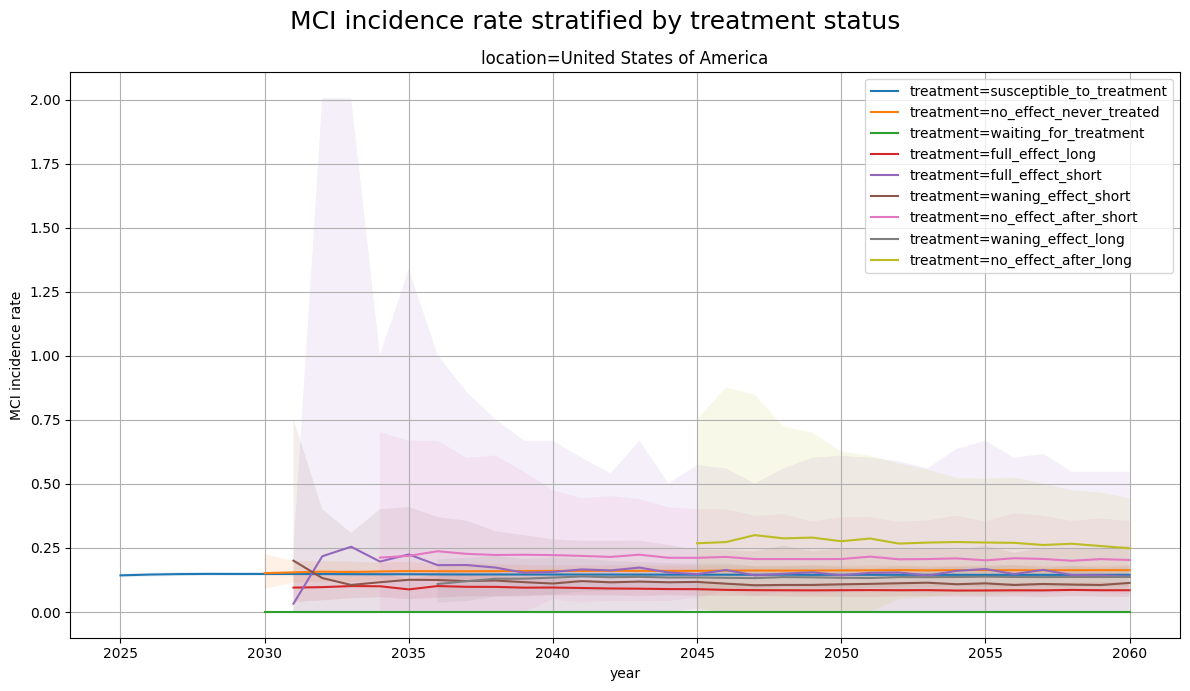

In [88]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    incidence_rates_by_treatment.loc[~inf].query("from_state=='alzheimers_blood_based_biomarker_state'"),
    'treatment',
    'location',
    ylabel='MCI incidence rate',
    suptitle='MCI incidence rate stratified by treatment status',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

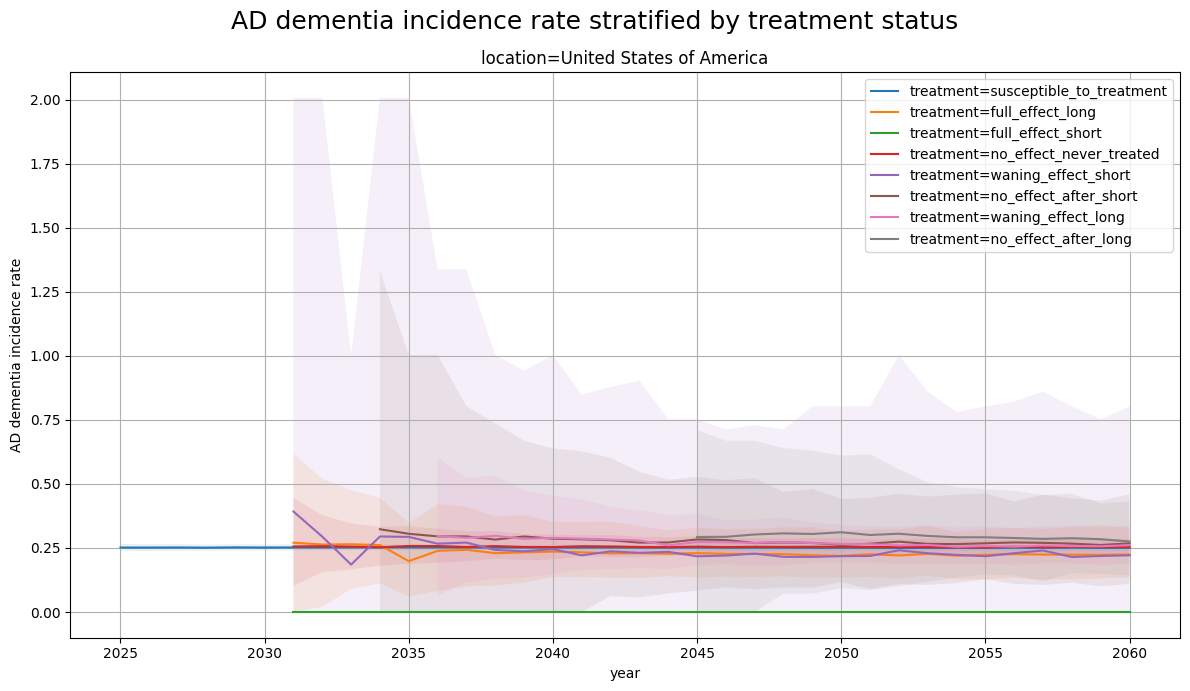

In [89]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    incidence_rates_by_treatment.loc[~inf].query("from_state=='alzheimers_mild_cognitive_impairment_state'"),
    'treatment',
    'location',
    ylabel='AD dementia incidence rate',
    suptitle='AD dementia incidence rate stratified by treatment status',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

## Compute hazard ratio

In [90]:
hazard_ratio = ops.ratio(
    incidence_rates_by_treatment,
    incidence_rates_by_treatment.query("treatment=='susceptible_to_treatment'"),
    strata=['event_year', 'from_state'],
    numerator_broadcast=['treatment'],
    # prefilter_query="from_state=='alzheimers_blood_based_biomarker_state'",
)
hazard_ratio

,event_year,from_state,random_seed,scenario,location,treatment,value,numerator_measure,denominator_measure,multiplier
0,2025,alzheimers_blood_based_biomarker_state,17,baseline,United States of America,susceptible_to_treatment,1.000000,transition_rate,transition_rate,1
1,2025,alzheimers_blood_based_biomarker_state,17,bbbm_testing_and_treatment,United States of America,susceptible_to_treatment,1.000000,transition_rate,transition_rate,1
2,2025,alzheimers_blood_based_biomarker_state,28,baseline,United States of America,susceptible_to_treatment,1.000000,transition_rate,transition_rate,1
3,2025,alzheimers_blood_based_biomarker_state,28,bbbm_testing_and_treatment,United States of America,susceptible_to_treatment,1.000000,transition_rate,transition_rate,1
4,2025,alzheimers_blood_based_biomarker_state,40,baseline,United States of America,susceptible_to_treatment,1.000000,transition_rate,transition_rate,1
...,...,...,...,...,...,...,...,...,...,...
271525,2060,alzheimers_mild_cognitive_impairment_state,9971,bbbm_testing_and_treatment,United States of America,no_effect_after_short,0.889169,transition_rate,transition_rate,1
271526,2060,alzheimers_mild_cognitive_impairment_state,9971,bbbm_testing_and_treatment,United States of America,no_effect_never_treated,1.053419,transition_rate,transition_rate,1
271527,2060,alzheimers_mild_cognitive_impairment_state,9971,bbbm_testing_and_treatment,United States of America,susceptible_to_treatment,1.000000,transition_rate,transition_rate,1
271528,2060,alzheimers_mild_cognitive_impairment_state,9971,bbbm_testing_and_treatment,United States of America,waning_effect_long,0.997582,transition_rate,transition_rate,1


In [91]:
hazard_ratio.value.describe()

count    2.715300e+05
mean              inf
std               NaN
min      0.000000e+00
25%      7.014789e-01
50%      1.000000e+00
75%      1.091072e+00
max               inf
Name: value, dtype: float64

In [92]:
inf_ratio = np.isinf(hazard_ratio.value)
print(inf_ratio.sum(), "rows with infinite values")

2687 rows with infinite values


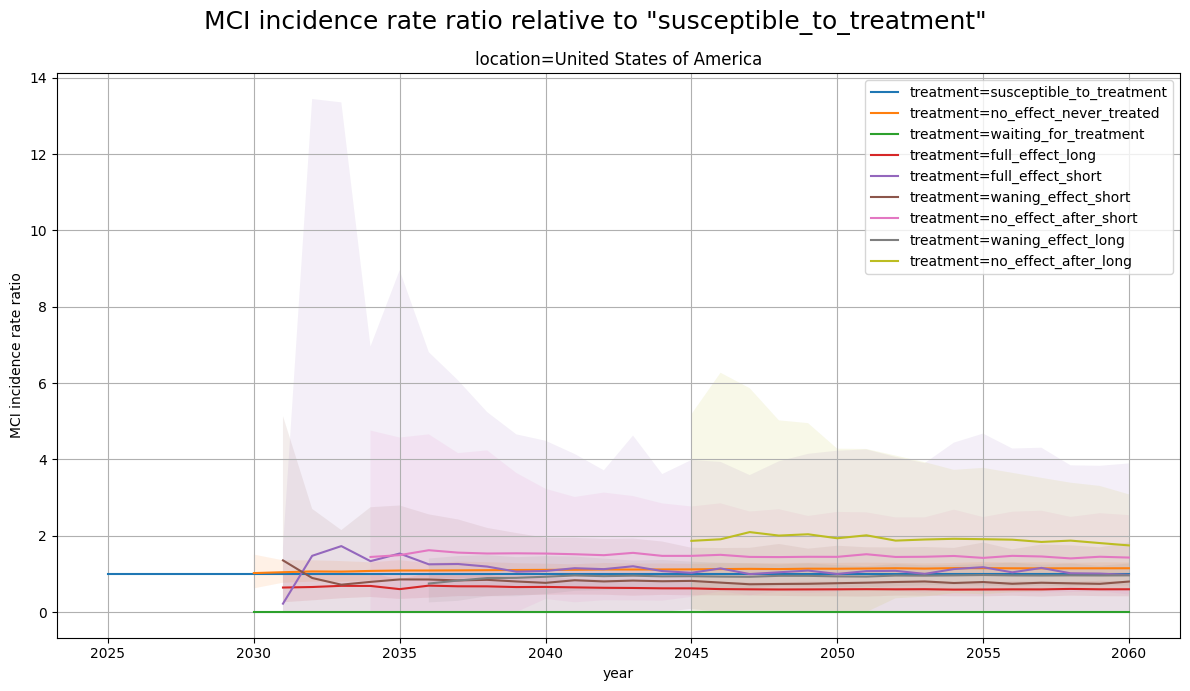

In [93]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    hazard_ratio.loc[~inf_ratio].query(
        "scenario=='bbbm_testing_and_treatment'"# and event_year > 2035"
        " and from_state=='alzheimers_blood_based_biomarker_state'"
        ),
    'treatment',
    'location',
    ylabel='MCI incidence rate ratio',
    suptitle='MCI incidence rate ratio relative to "susceptible_to_treatment"',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

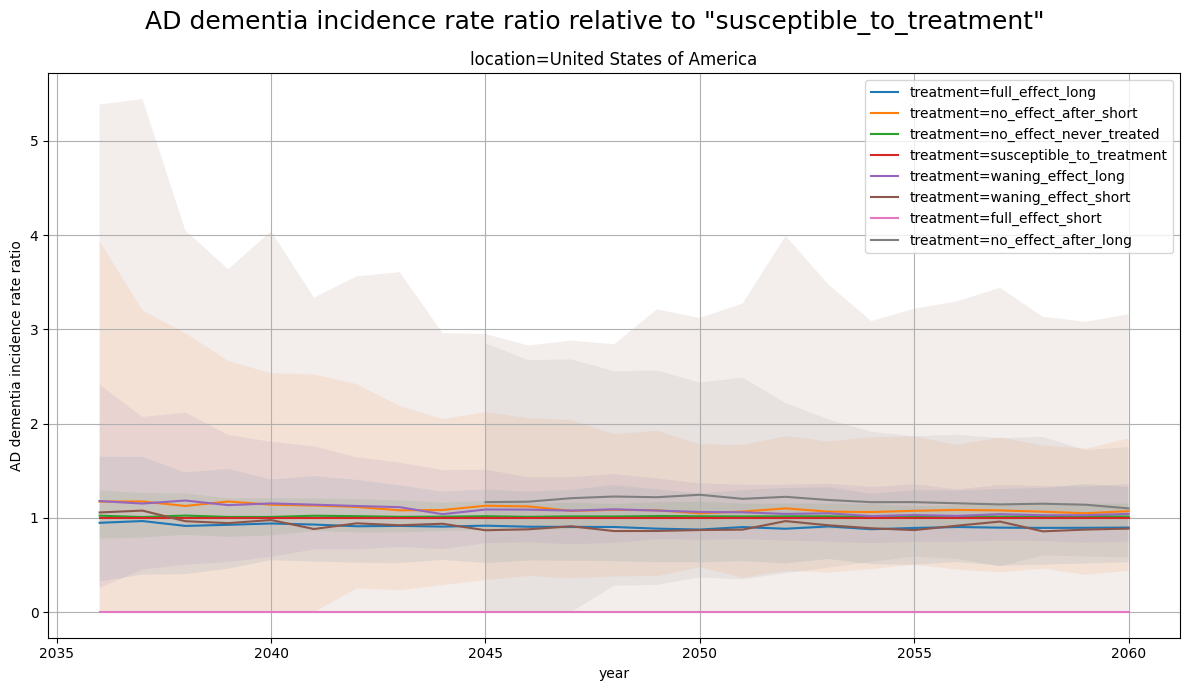

In [94]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    hazard_ratio.loc[~inf_ratio].query(
        "scenario=='bbbm_testing_and_treatment' and event_year > 2035"
        " and from_state=='alzheimers_mild_cognitive_impairment_state'"
        ),
    'treatment',
    'location',
    ylabel='AD dementia incidence rate ratio',
    suptitle='AD dementia incidence rate ratio relative to "susceptible_to_treatment"',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

# Results!

# Load deaths and plot averted deaths by scenario

In [95]:
deaths = load_sim_output('deaths', aggregate_seeds=False)
print_memory_usage(deaths)
deaths

45.383918 MB


,measure,entity_type,entity,age_group,event_year,sex,artifact_path,scenario,input_draw,random_seed,value,location
0,deaths,cause,alzheimers_disease_state,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
1,deaths,cause,alzheimers_disease_state,25_to_29,2025,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
2,deaths,cause,alzheimers_disease_state,25_to_29,2026,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
3,deaths,cause,alzheimers_disease_state,25_to_29,2026,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
4,deaths,cause,alzheimers_disease_state,25_to_29,2027,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.0,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...
2159995,deaths,cause,other_causes,95_plus,2058,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,108.0,United States of America
2159996,deaths,cause,other_causes,95_plus,2059,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,270.0,United States of America
2159997,deaths,cause,other_causes,95_plus,2059,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,116.0,United States of America
2159998,deaths,cause,other_causes,95_plus,2060,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,282.0,United States of America


In [96]:
# NOTE: I had to rework some code in my vph_output.operators.difference
# function to prevent this code from converting Categoricals back to
# strings and making the memory explode...
averted_deaths = ops.averted(deaths, baseline_scenario='baseline')
print_memory_usage(averted_deaths)
# convert_dtypes(averted_deaths, colname_to_dtype=colname_to_categorical_dtype, inplace=True)
# print_memory_usage(averted_deaths)
# convert_to_categorical(averted_deaths, inplace=True)
# print_memory_usage(averted_deaths)
averted_deaths

45.383918 MB measure
31.343786 MB minuend
31.343786 MB subtrahend
21.626748 MB minuend re-indexed
21.626748 MB subtrahend re-indexed
21.626808 MB difference
29.183918 MB difference with reset index
30.264243 MB final difference
30.264243 MB


,measure,entity_type,entity,age_group,event_year,sex,artifact_path,input_draw,random_seed,location,scenario,subtracted_from,value
0,deaths,cause,alzheimers_disease_state,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,2047,United States of America,bbbm_testing_and_treatment,baseline,0.0
1,deaths,cause,alzheimers_disease_state,25_to_29,2025,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,2047,United States of America,bbbm_testing_and_treatment,baseline,0.0
2,deaths,cause,alzheimers_disease_state,25_to_29,2026,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,2047,United States of America,bbbm_testing_and_treatment,baseline,0.0
3,deaths,cause,alzheimers_disease_state,25_to_29,2026,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,2047,United States of America,bbbm_testing_and_treatment,baseline,0.0
4,deaths,cause,alzheimers_disease_state,25_to_29,2027,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,2047,United States of America,bbbm_testing_and_treatment,baseline,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079995,deaths,cause,other_causes,95_plus,2058,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,3528,United States of America,bbbm_testing_and_treatment,baseline,0.0
1079996,deaths,cause,other_causes,95_plus,2059,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,3528,United States of America,bbbm_testing_and_treatment,baseline,-1.0
1079997,deaths,cause,other_causes,95_plus,2059,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,3528,United States of America,bbbm_testing_and_treatment,baseline,0.0
1079998,deaths,cause,other_causes,95_plus,2060,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,3528,United States of America,bbbm_testing_and_treatment,baseline,-1.0


In [97]:
averted_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080000 entries, 0 to 1079999
Data columns (total 13 columns):
 #   Column           Non-Null Count    Dtype   
---  ------           --------------    -----   
 0   measure          1080000 non-null  category
 1   entity_type      1080000 non-null  category
 2   entity           1080000 non-null  category
 3   age_group        1080000 non-null  category
 4   event_year       1080000 non-null  int64   
 5   sex              1080000 non-null  category
 6   artifact_path    1080000 non-null  category
 7   input_draw       1080000 non-null  category
 8   random_seed      1080000 non-null  category
 9   location         1080000 non-null  category
 10  scenario         1080000 non-null  category
 11  subtracted_from  1080000 non-null  category
 12  value            1080000 non-null  float64 
dtypes: category(11), float64(1), int64(1)
memory usage: 28.9 MB


In [98]:
averted_deaths['scenario'].dtype.categories

Index(['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment'], dtype='object')

In [99]:
averted_deaths.index.memory_usage(deep=True)

132

In [100]:
averted_deaths.entity.unique()

['alzheimers_disease_state', 'other_causes']
Categories (2, object): ['alzheimers_disease_state', 'other_causes']

In [101]:
averted_deaths.value.describe()

count    1.080000e+06
mean     4.101204e-02
std      6.558405e-01
min     -1.000000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+01
Name: value, dtype: float64

In [102]:
# convert_dtypes(averted_deaths, colname_to_categorical_dtype, inplace=True)
# convert_to_categorical(averted_deaths, inplace=True)
print_memory_usage(averted_deaths)

30.264243 MB


In [103]:
# FIXME: Wait, to get percent deaths averted, do I want to be dividing
# by deaths in the intervention scenarios (like I do here), or should I
# be dividing by deaths in the *baseline* scenario? Probably the
# latter...
print_memory_usage(averted_deaths)
averted_deaths_pct = ops.ratio(
    averted_deaths,
    deaths.query("scenario != 'baseline'"),
    strata=['entity', 'age_group', 'event_year'],
    dropna=True, # Drop strata in younger age groups where we divided by 0
    multiplier=100,
)
print_memory_usage(averted_deaths_pct)
# convert_dtypes(averted_deaths_pct, colname_to_categorical_dtype, inplace=True)
# print_memory_usage(averted_deaths_pct)
# convert_to_categorical(averted_deaths_pct, inplace=True)
# print_memory_usage(averted_deaths_pct)
averted_deaths_pct

30.264243 MB
11.959712 MB


,entity,age_group,event_year,random_seed,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,alzheimers_disease_state,40_to_44,2025,2718,bbbm_testing_and_treatment,United States of America,0.000000,deaths,deaths,100
1,alzheimers_disease_state,40_to_44,2025,7137,bbbm_testing_and_treatment,United States of America,0.000000,deaths,deaths,100
2,alzheimers_disease_state,40_to_44,2025,7927,bbbm_testing_and_treatment,United States of America,0.000000,deaths,deaths,100
3,alzheimers_disease_state,40_to_44,2025,3240,bbbm_testing_and_treatment,United States of America,0.000000,deaths,deaths,100
4,alzheimers_disease_state,40_to_44,2025,4758,bbbm_testing_and_treatment,United States of America,0.000000,deaths,deaths,100
...,...,...,...,...,...,...,...,...,...,...
373007,other_causes,95_plus,2060,3093,bbbm_testing_and_treatment,United States of America,-1.187648,deaths,deaths,100
373008,other_causes,95_plus,2060,9584,bbbm_testing_and_treatment,United States of America,-0.507614,deaths,deaths,100
373009,other_causes,95_plus,2060,8610,bbbm_testing_and_treatment,United States of America,-0.234742,deaths,deaths,100
373010,other_causes,95_plus,2060,9450,bbbm_testing_and_treatment,United States of America,0.000000,deaths,deaths,100


In [104]:
averted_deaths_pct.memory_usage(deep=True)

Index                      132
entity                  373270
age_group               374542
event_year             2984096
random_seed             766576
scenario                373337
location                373201
value                  2984096
numerator_measure       373183
denominator_measure     373183
multiplier             2984096
dtype: int64

In [105]:
ops.stratify(averted_deaths, 'event_year')

,event_year,random_seed,scenario,location,value
0,2025,2047,bbbm_testing_and_treatment,United States of America,0.0
1,2025,6810,bbbm_testing_and_treatment,United States of America,0.0
2,2025,4622,bbbm_testing_and_treatment,United States of America,0.0
3,2025,1209,bbbm_testing_and_treatment,United States of America,0.0
4,2025,9449,bbbm_testing_and_treatment,United States of America,0.0
...,...,...,...,...,...
17995,2060,3093,bbbm_testing_and_treatment,United States of America,0.0
17996,2060,9584,bbbm_testing_and_treatment,United States of America,-3.0
17997,2060,8610,bbbm_testing_and_treatment,United States of America,0.0
17998,2060,9450,bbbm_testing_and_treatment,United States of America,7.0


In [106]:
# # FIXME: For some reason, this was taking a long time (>30 seconds before I interrupted it)
# averted_deaths_summary = summarize_sim_data(averted_deaths)
# averted_deaths_summary

In [107]:
def f(a=None, *args, **kwargs):
    print(a, args, kwargs)

f(1,2,3)
f(2)
f(5, b=4)
f(5, 6, b=7)
f(a=5, b=7)
f()

1 (2, 3) {}
2 () {}
5 () {'b': 4}
5 (6,) {'b': 7}
5 () {'b': 7}
None () {}


In [108]:
f(2)

2 () {}


# Draw results plots

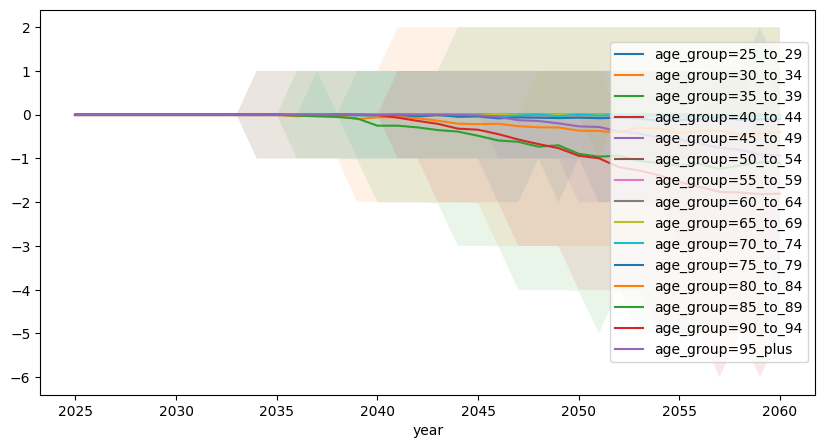

In [109]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(averted_deaths.query(
    "scenario == 'bbbm_testing_and_treatment' and entity == 'other_causes'"
    f" and location=={locations[0]!r}"
    ),
    'age_group'
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()


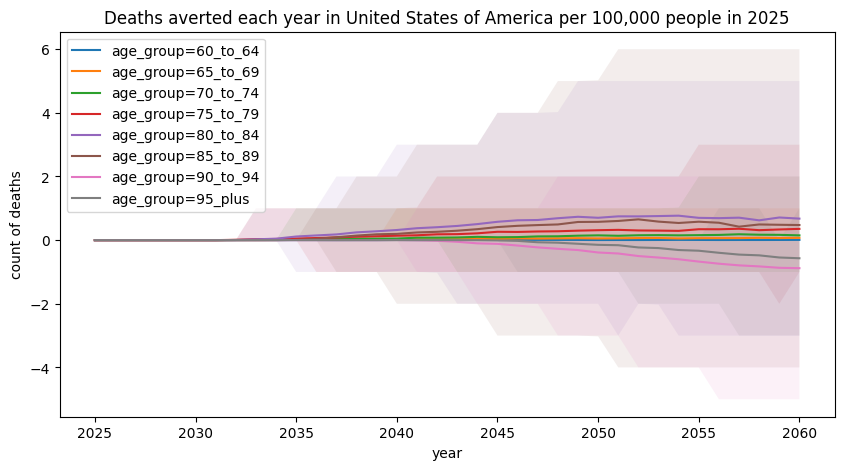

In [110]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment'" #and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="count of deaths",
    title=f"Deaths averted each year in {locations[0]} per 100,000 people in 2025"
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()

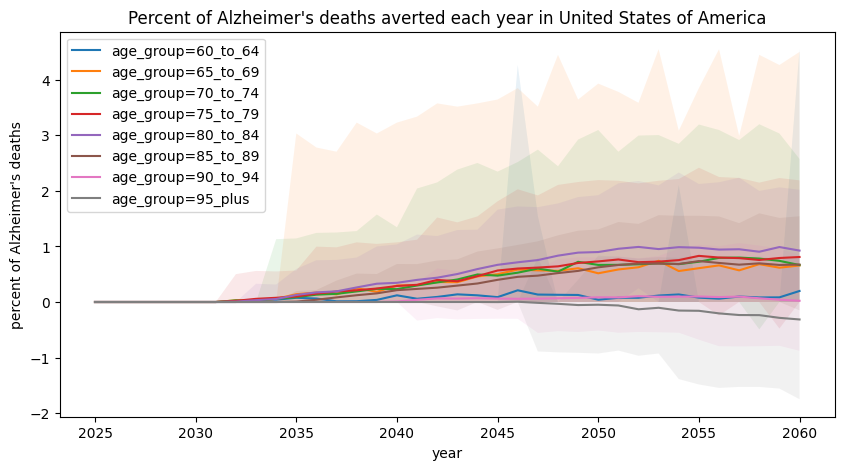

In [111]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_deaths_pct
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="percent of Alzheimer's deaths",
    title=f"Percent of Alzheimer's deaths averted each year in {locations[0]}"
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()

In [112]:
deaths.scenario.unique()

['baseline', 'bbbm_testing_and_treatment']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

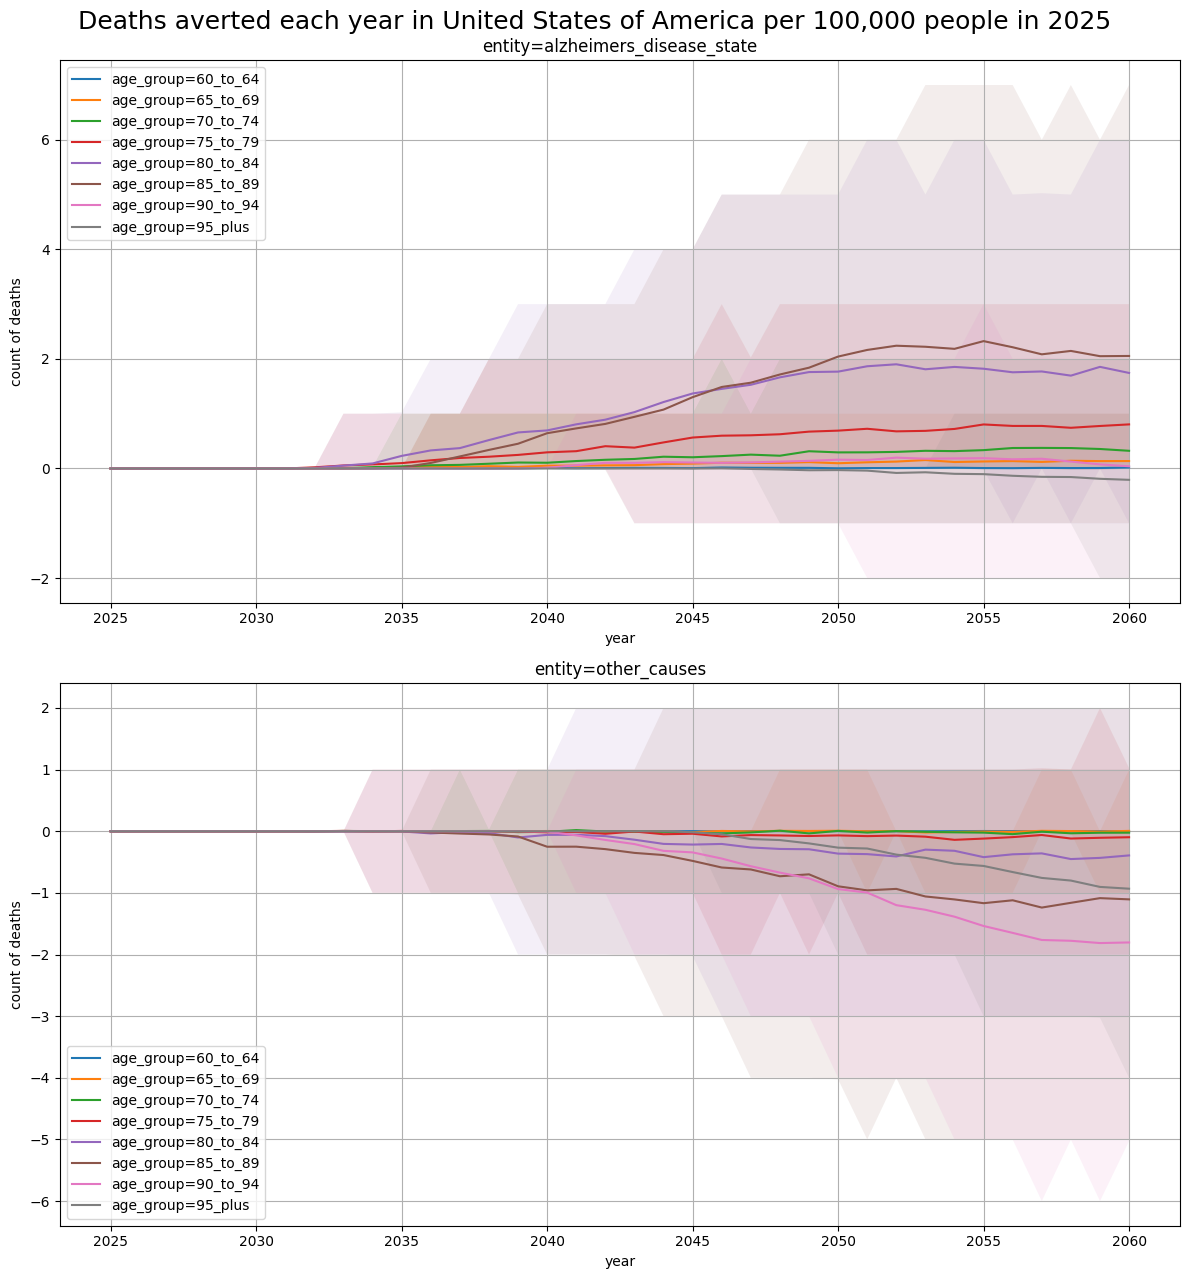

In [113]:
location = locations[0]
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and location==@location"
        ),
    'age_group',
    'entity',
    ylabel="count of deaths",
    suptitle=f"Deaths averted each year in {location} per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Absolute reductions in AD deaths for all countries

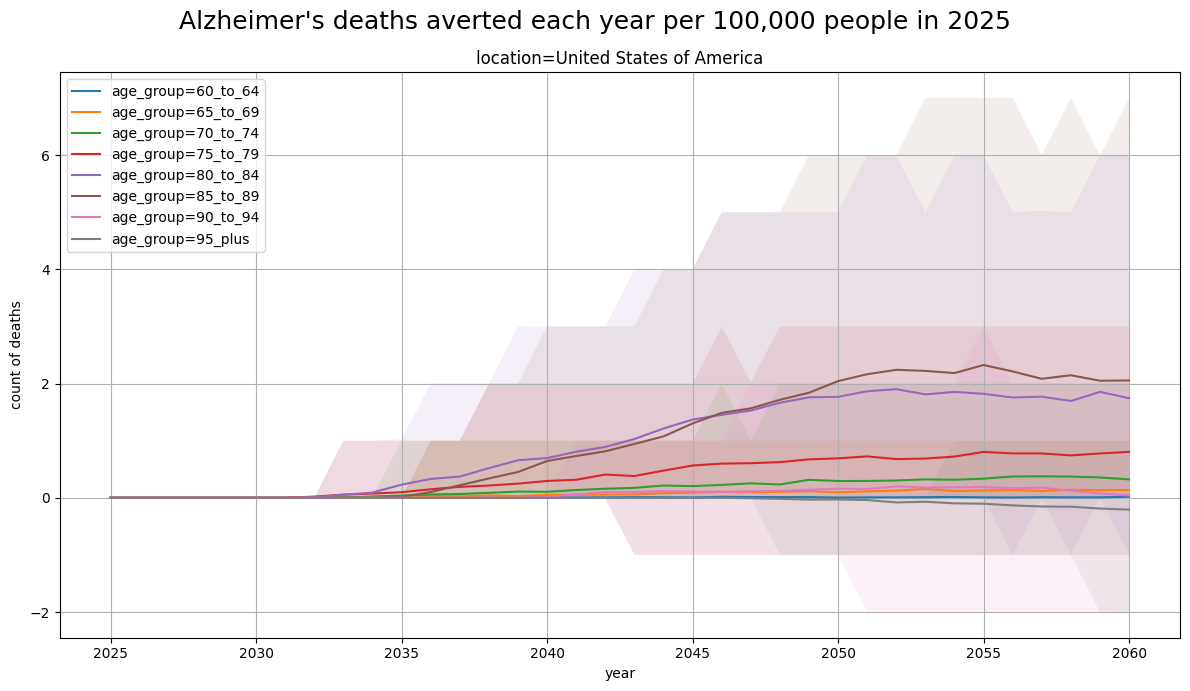

In [114]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="count of deaths",
    suptitle=f"Alzheimer's deaths averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Percent reductions in deaths for all countries

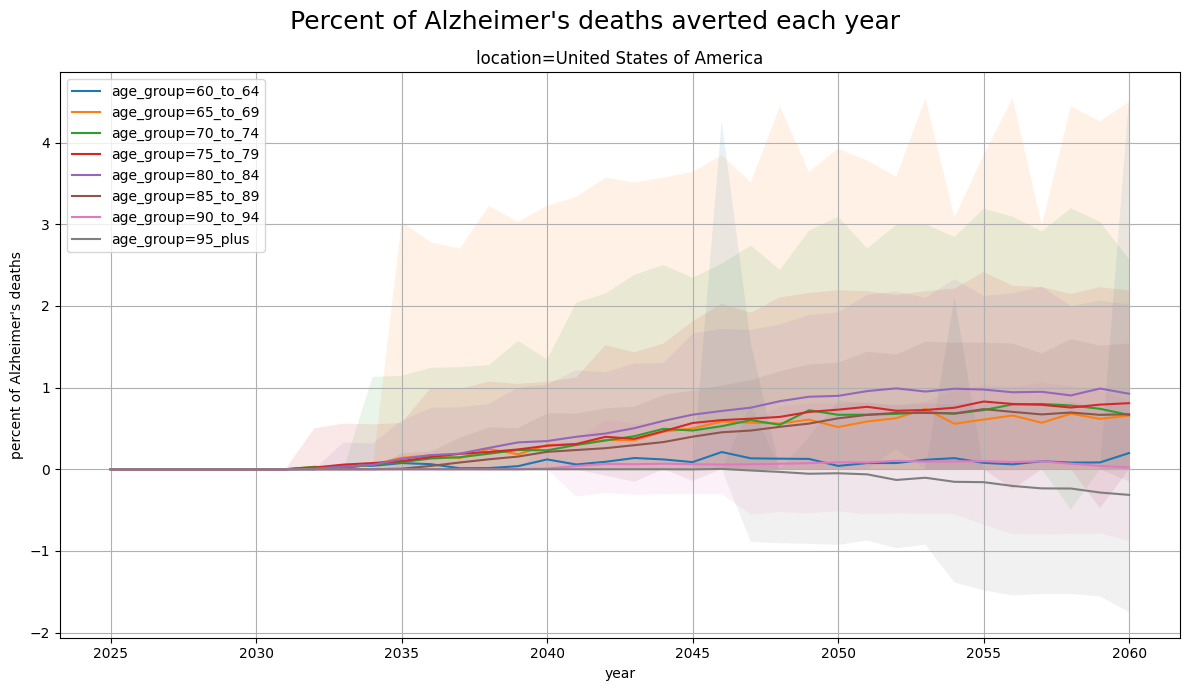

In [115]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths_pct
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="percent of Alzheimer's deaths",
    suptitle=f"Percent of Alzheimer's deaths averted each year"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Load YLLs and plot averted YLLs

In [116]:
ylls = load_sim_output('ylls', aggregate_seeds=False)
print_memory_usage(ylls)
ylls

45.383916 MB


,measure,entity_type,entity,age_group,event_year,sex,artifact_path,scenario,input_draw,random_seed,value,location
0,ylls,cause,alzheimers_disease_state,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
1,ylls,cause,alzheimers_disease_state,25_to_29,2025,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
2,ylls,cause,alzheimers_disease_state,25_to_29,2026,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
3,ylls,cause,alzheimers_disease_state,25_to_29,2026,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
4,ylls,cause,alzheimers_disease_state,25_to_29,2027,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...
2159995,ylls,cause,other_causes,95_plus,2058,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,882.142871,United States of America
2159996,ylls,cause,other_causes,95_plus,2059,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,2201.284108,United States of America
2159997,ylls,cause,other_causes,95_plus,2059,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,947.274664,United States of America
2159998,ylls,cause,other_causes,95_plus,2060,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,2294.350899,United States of America


In [117]:
averted_ylls = ops.averted(ylls, baseline_scenario='baseline')
print_memory_usage(averted_ylls)

45.383916 MB measure
31.343784 MB minuend
31.343784 MB subtrahend


21.626746 MB minuend re-indexed
21.626746 MB subtrahend re-indexed
21.626806 MB difference
29.183916 MB difference with reset index
30.264241 MB final difference
30.264241 MB


In [118]:
averted_ylls.entity.unique()

['alzheimers_disease_state', 'other_causes']
Categories (2, object): ['alzheimers_disease_state', 'other_causes']

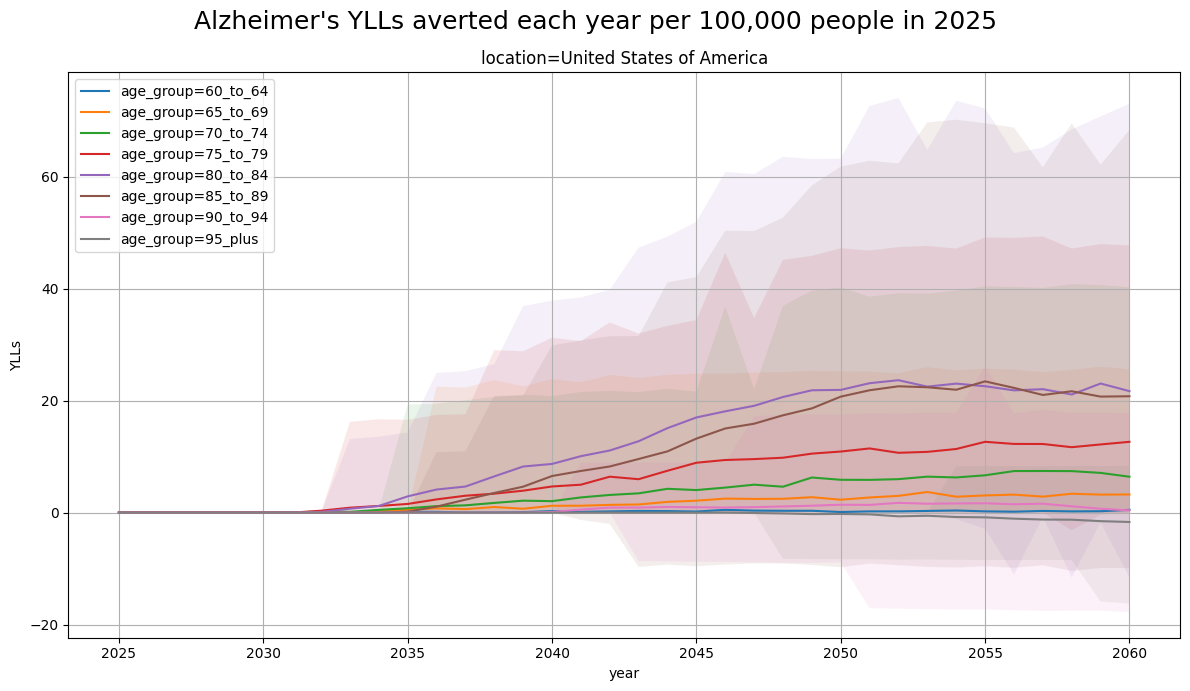

In [119]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="YLLs",
    suptitle=f"Alzheimer's YLLs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    ax.grid(True)
plt.show()

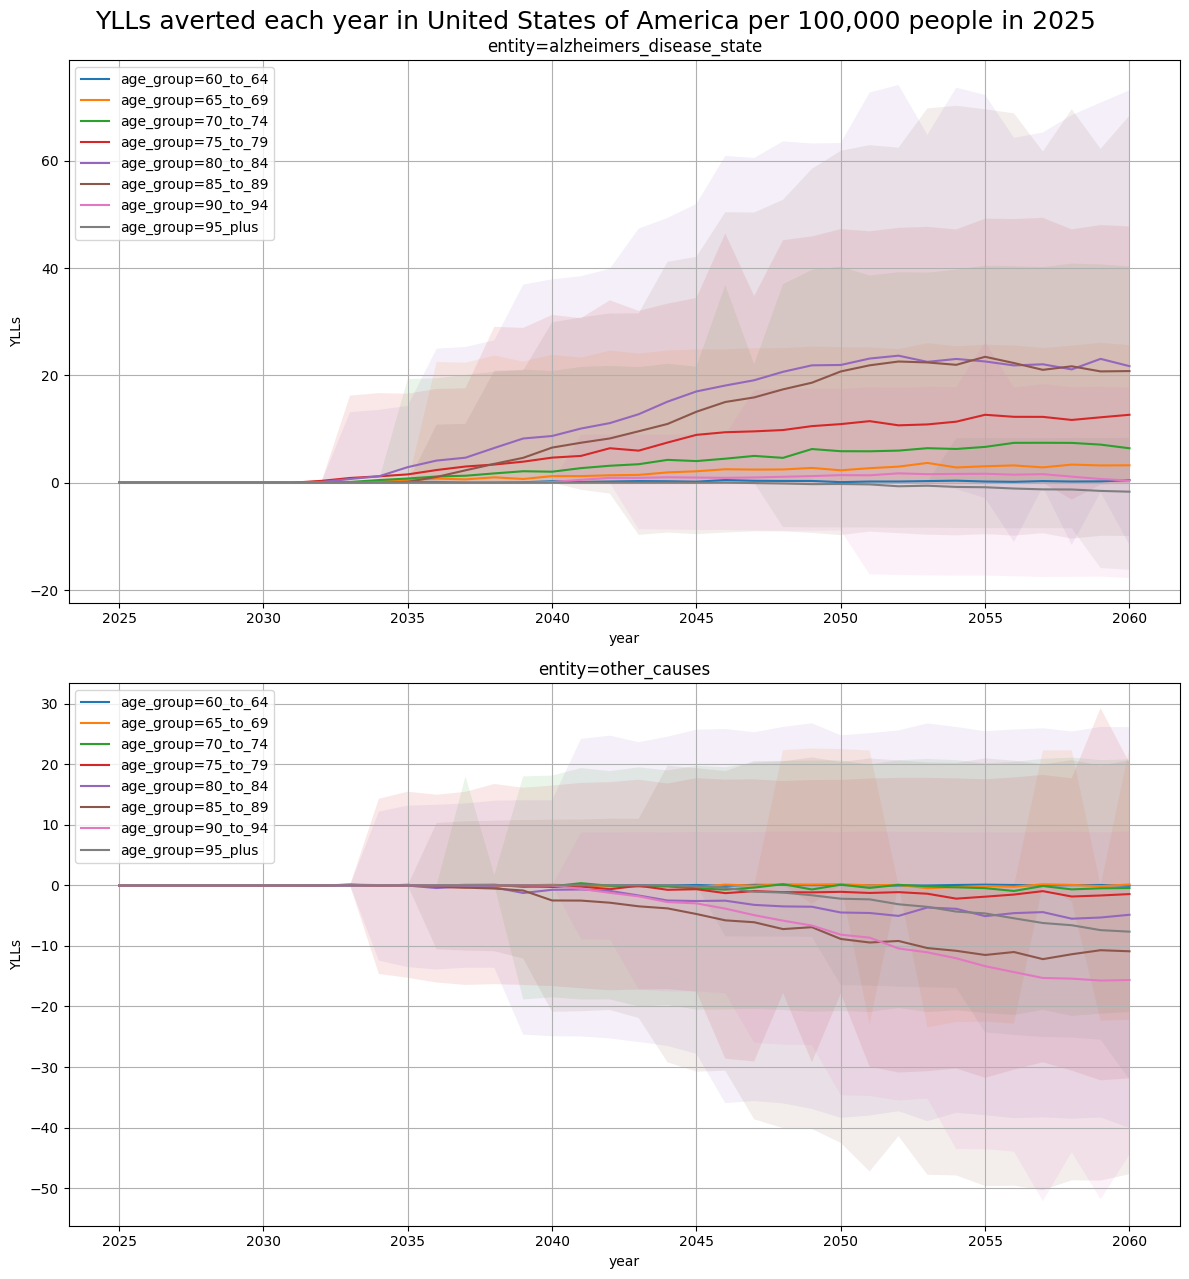

In [120]:
location = locations[0]
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and location==@location"
        ),
    'age_group',
    'entity',
    ylabel="YLLs",
    suptitle=f"YLLs averted each year in {location} per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

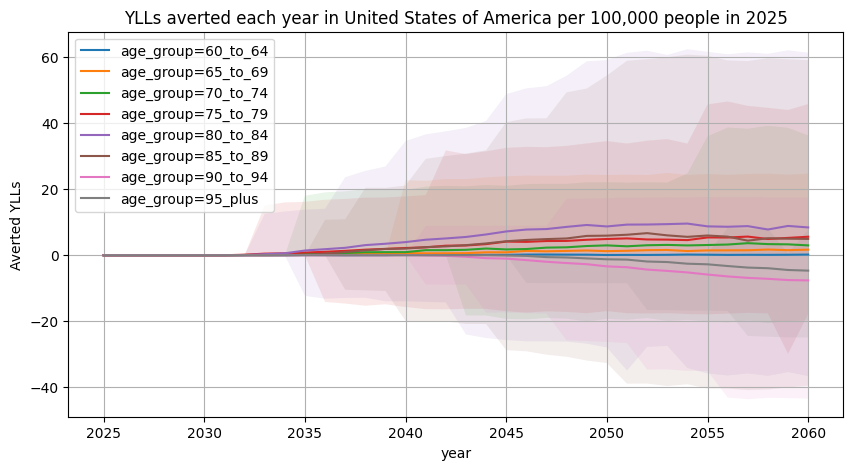

In [121]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment'" #and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="Averted YLLs",
    title=f"YLLs averted each year in {locations[0]} per 100,000 people in 2025"
)
# ax.set_xticks(ax.get_xticks()[::10])
ax.grid(True)
plt.show()

# Load YLDs and plot averted YLDs

In [122]:
ylds = load_sim_output('ylds', aggregate_seeds=False)
print_memory_usage(ylds)
ylds

285.145247 MB


,measure,entity_type,entity,sub_entity,age_group,event_year,sex,artifact_path,scenario,input_draw,random_seed,value,location
0,ylds,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
1,ylds,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
2,ylds,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
3,ylds,cause,treatment,waiting_for_treatment,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
4,ylds,cause,treatment,full_effect_long,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,baseline,457,3167,0.000000,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12959995,ylds,cause,treatment,waning_effect_short,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.000000,United States of America
12959996,ylds,cause,treatment,no_effect_after_long,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.000000,United States of America
12959997,ylds,cause,treatment,no_effect_after_short,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.000000,United States of America
12959998,ylds,cause,treatment,no_effect_never_treated,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,bbbm_testing_and_treatment,457,3528,0.000000,United States of America


In [123]:
averted_ylds = ops.averted(ylds, baseline_scenario='baseline')
print_memory_usage(averted_ylds)
# This converts years from int64 to int16
# convert_dtypes(averted_ylds, colname_to_dtype, inplace=True)
averted_ylds = averted_ylds.astype(colname_to_dtype, copy=False)
print_memory_usage(averted_ylds)
# This would convert integer years to Categorical
# convert_to_categorical(averted_ylds, inplace=True)
# print_memory_usage(averted_ylds)

285.145247 MB measure
194.425115 MB minuend
194.425115 MB subtrahend
136.108149 MB minuend re-indexed
136.108149 MB subtrahend re-indexed
136.108209 MB difference
181.465247 MB difference with reset index
187.945572 MB final difference
187.945572 MB
149.065572 MB


In [124]:
1086.443257 / 27.372526

39.69101196579373

In [125]:
averted_ylds.memory_usage(deep=True)

Index                   132
measure             6480169
entity_type         6480170
entity              6480336
sub_entity          6481253
age_group           6481530
event_year         12960000
sex                 6480232
artifact_path       6480243
input_draw          6480116
random_seed        12980552
location            6480189
scenario            6480325
subtracted_from     6480325
value              51840000
dtype: int64

In [126]:
averted_ylds.dtypes

measure            category
entity_type        category
entity             category
sub_entity         category
age_group          category
event_year            int16
sex                category
artifact_path      category
input_draw         category
random_seed        category
location           category
scenario           category
subtracted_from    category
value               float64
dtype: object

In [127]:
averted_ylds

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,artifact_path,input_draw,random_seed,location,scenario,subtracted_from,value
0,ylds,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,2047,United States of America,bbbm_testing_and_treatment,baseline,0.000000
1,ylds,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,2047,United States of America,bbbm_testing_and_treatment,baseline,0.000000
2,ylds,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,2047,United States of America,bbbm_testing_and_treatment,baseline,0.000000
3,ylds,cause,treatment,waiting_for_treatment,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,2047,United States of America,bbbm_testing_and_treatment,baseline,0.000000
4,ylds,cause,treatment,full_effect_long,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,2047,United States of America,bbbm_testing_and_treatment,baseline,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6479995,ylds,cause,treatment,waning_effect_short,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,3528,United States of America,bbbm_testing_and_treatment,baseline,0.000000
6479996,ylds,cause,treatment,no_effect_after_long,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,3528,United States of America,bbbm_testing_and_treatment,baseline,0.000000
6479997,ylds,cause,treatment,no_effect_after_short,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,3528,United States of America,bbbm_testing_and_treatment,baseline,0.000000
6479998,ylds,cause,treatment,no_effect_never_treated,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,3528,United States of America,bbbm_testing_and_treatment,baseline,0.000000


In [128]:
averted_ylds.entity.unique()

['alzheimers_disease_and_other_dementias', 'treatment', 'all_causes']
Categories (3, object): ['all_causes', 'alzheimers_disease_and_other_dementias', 'treatment']

In [129]:
# All values are 0 in this sub-dataframe
averted_ylds.query("entity=='treatment'")

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,artifact_path,input_draw,random_seed,location,scenario,subtracted_from,value
3,ylds,cause,treatment,waiting_for_treatment,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,2047,United States of America,bbbm_testing_and_treatment,baseline,0.0
4,ylds,cause,treatment,full_effect_long,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,2047,United States of America,bbbm_testing_and_treatment,baseline,0.0
5,ylds,cause,treatment,full_effect_short,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,2047,United States of America,bbbm_testing_and_treatment,baseline,0.0
6,ylds,cause,treatment,waning_effect_long,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,2047,United States of America,bbbm_testing_and_treatment,baseline,0.0
7,ylds,cause,treatment,waning_effect_short,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,2047,United States of America,bbbm_testing_and_treatment,baseline,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6479994,ylds,cause,treatment,waning_effect_long,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,3528,United States of America,bbbm_testing_and_treatment,baseline,0.0
6479995,ylds,cause,treatment,waning_effect_short,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,3528,United States of America,bbbm_testing_and_treatment,baseline,0.0
6479996,ylds,cause,treatment,no_effect_after_long,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,3528,United States of America,bbbm_testing_and_treatment,baseline,0.0
6479997,ylds,cause,treatment,no_effect_after_short,95_plus,2060,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,3528,United States of America,bbbm_testing_and_treatment,baseline,0.0


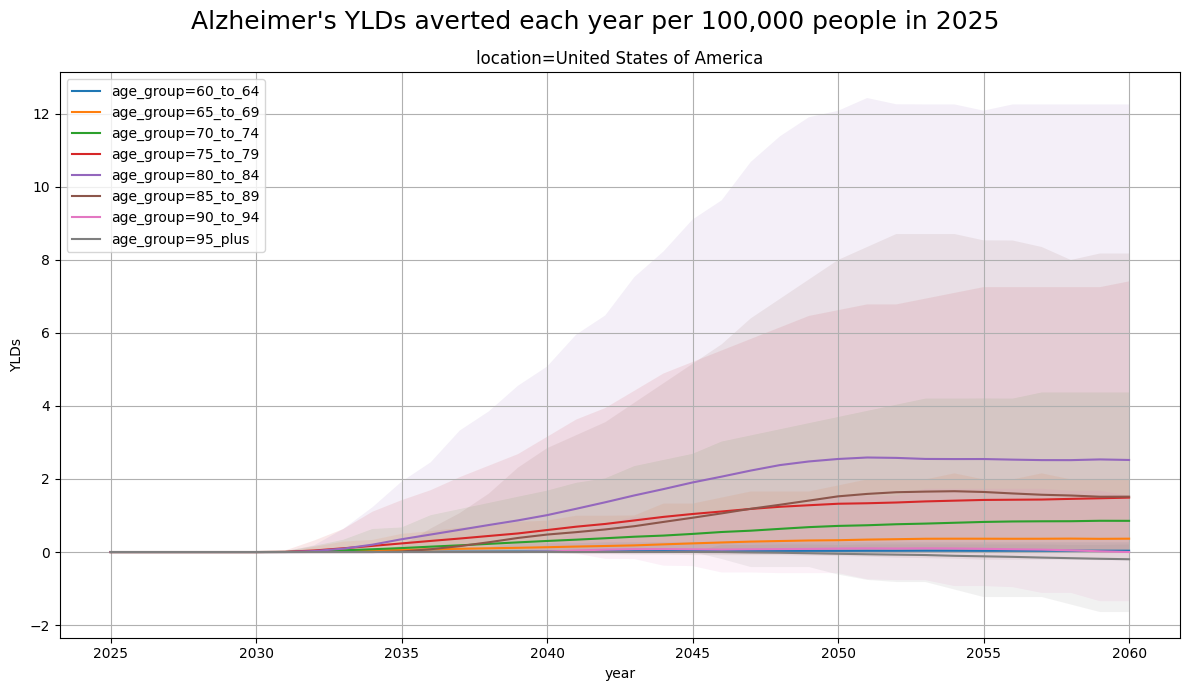

In [130]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylds
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_and_other_dementias'"
        ),
    'age_group',
    'location',
    ylabel="YLDs",
    suptitle=f"Alzheimer's YLDs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

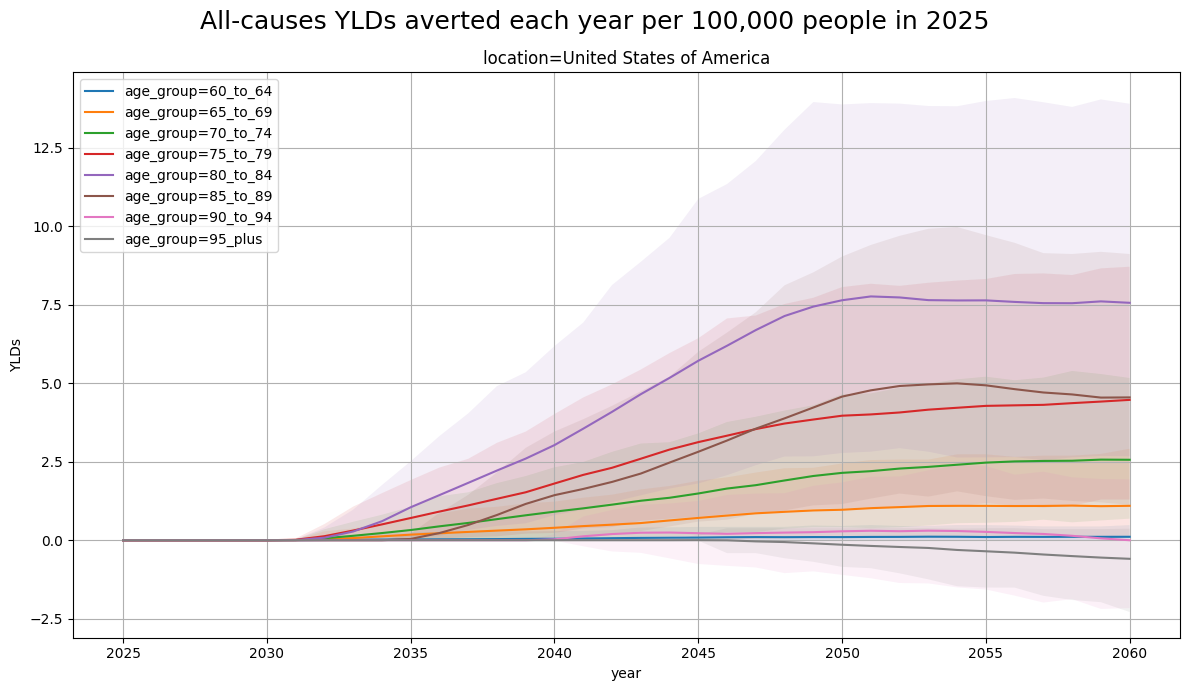

In [131]:
# I'm not sure why total YLDs averted is greater than Alzheimer's YLDs
# averted...
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylds
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'all_causes'"
        ),
    'age_group',
    'location',
    ylabel="YLDs",
    suptitle=f"All-causes YLDs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

In [132]:
# Print current time to easily check if notebook ran all the way through
# vs. hitting an error somewhere above
import datetime
print(datetime.datetime.now())

2025-10-28 23:56:40.092562
